### **Predicting Number of Shares of Mashable News Articles**
Joseph P. Martin

Phase 2, Module 15: Capstone 2: Supervised Learning Capstone

Checkpoint 1: Capstone: Supervised Learning

####**Task 1**
**Find a dataset of interest.** It could be from one of the recommended resources or some other aggregation. It could also be something that we scraped ourselves. Just make sure that it has lots of variables, including an outcome of interest to us.

#####**Introduction**

The dataset considered here is for articles from the news site mashable.com that have been shared on social media platforms.

The dataset was obtained from https://www.kaggle.com/yamqwe/predicting-number-of-shares-of-news-articles, but it originally comes from this project:
"K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal." The project article was consulted for all information about the dataset stated below.

The outcome of interest is the number of times each article is shared. There are numerous features provided and these are explained and explored below.

Set up environment.

In [ ]:
# Set up environment.

import graphviz # package for rendering decision tree
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pydotplus # package for rendering decision tree
import seaborn as sn
import statistics
import statsmodels.api as sm
import time

from IPython.display import Image # a convenience for displaying visualizations
from mlxtend.plotting import plot_decision_regions
from scipy import stats
from sklearn import ensemble
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# display preferences
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read in the dataset.

In [ ]:
# Read in the dataset. 
# Storing the dataset on github avoids the authentication issue that occurs if 
# it is stored on Google Drive. It could not be read from Kaggle directly.
onp_orig_df = pd.read_csv('https://raw.githubusercontent.com/JosephMartin610/thinkful_data_science_flex/main/OnlineNewsPopularity.csv')

####**Task 2**
**Explore the data.** Get to know the data. Spend a lot of time going over its quirks. We should understand how it was gathered, what is in it, and what the variables look like.

#####**Initial Exploration of Dataset**

The researchers created the dataset by retrieving the content of all articles published during a two year period on Mashable, a news website. The data were collected during a two year period, from January 7, 2013 to January 7, 2015. Therefore, the data are somewhat outdated, and may not be applicable to the current environment of articles being shared on social media, but there is likely enough here to be informative in the context of this course. 

Mashable articles have metadata, such as keywords, data channel type, and total number of shares (Facebook, Twitter, Google+, LinkedIn, Stumble-Upon, Pinterest).

Categorical variables were encoded into multiple binary variables.

Determine shape of the DataFrame.

In [ ]:
# Determine shape of the DataFrame.
onp_orig_df.shape

(39644, 61)

There are 39,644 rows and 61 columns.

Obtain a concise summary of the DataFrame.

In [ ]:
# Obtain a concise summary of the DataFrame.
onp_orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  int64  
 2   n_tokens_title                 39644 non-null  int64  
 3   n_tokens_content               39644 non-null  int64  
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  int64  
 8   num_self_hrefs                 39644 non-null  int64  
 9   num_imgs                       39644 non-null  int64  
 10  num_videos                     39644 non-null  int64  
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

Obtain head of the DataFrame.

In [ ]:
# Obtain head of the DataFrame.
onp_orig_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,5,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1,0,0,0,0,0,0,0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,4,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,6,0,0,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1,0,0,0,0,0,0,0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,7,0,1,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0,0,0,0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,7,0,0,0,0,1,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1,0,0,0,0,0,0,0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


All of of the columns are numerical, except for the first column, 'url'. Of the numerical columns all are of type float64, except 'shares', which is int64, and the numbers of shares are whole numbers, as expected. This initial summary indicates there are not any missing (null) data in any of the columns.

Determine summary statistics.

In [ ]:
# Determine summary statistics.
onp_orig_df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,0.052946,0.178009,0.157855,0.058597,0.185299,0.212567,26.106801,1153.951682,312.366967,13612.354102,752324.066694,259281.938083,1117.146610,5657.211151,3135.858639,3998.755396,10329.212662,6401.697580,0.168020,0.186409,0.187544,0.183306,0.143805,0.061876,0.069039,0.130915,0.184599,0.141256,0.216321,0.223770,0.234029,0.443370,0.119309,0.039625,0.016612,0.682150,0.287934,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,0.223929,0.382525,0.364610,0.234871,0.388545,0.409129,69.633215,3857.990877,620.783887,57986.029357,214502.129573,135102.247285,1137.456951,6098.871957,1318.150397,19738.670516,41027.576613,24211.332231,0.373889,0.389441,0.390353,0.386922,0.350896,0.240933,0.253524,0.337312,0.262975,0.219707,0.282145,0.295191,0.289183,0.116685,0.096931,0.017429,0.010828,0.190206,0.156156,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,141.750000,0.000000,843300.000000,172846.875000,0.000000,3562.101631,2382.448565,639.000000,1100.000000,981.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025051,0.025012,0.028571,0.028571,0.0

The follwowing is information we have learned about the columns provided with the dataset.

As claimed, categorical variables have been encoded into multiple binary variables.

url (column: 0):
*   URL of the article

timedelta (column: 1):
*   days between the article publication and the dataset acquisition
*   The range does not completely agree with the statement in the article 'We 
also discarded very recent articles (less than 3 weeks)' because the minimum is 8 days. The maximum of 731 days is only slightly more than 2 years = 2*365.25 = 730.5 days, so that is acceptable.

'Words' features:

n_tokens_title (column: 2):
*   number of words in the title
*   The range and quartiles here are acceptable.

n_tokens_content (column: 3):
*   number of words in the content
*   The range and quartiles here are acceptable, except for the 0s.

average_token_length (column: 11):
*   average length of the words in the content (average number of letters)
*   The range and quartiles here are acceptable, except for the 0s.

n_non_stop_words (column: 5):              
*   rate of non-stop words in the content
*   Stop words are the words that do not add much meaning to a sentence, so here "non-stop" words are likely the words that add meaning.
*   Whether these values are acceptable is investigated below. Why are there 0s, why is 1 the dominant average value, and why is the maximum 1042 if this is supposed to be a rate?

n_unique_tokens (column: 4):
*   rate of unique words in the content
*   Whether these values are acceptable is investigated below. Why are there 0s, and why is the maximum 701 if this is supposed to be a rate? There should not be more unique words than overall words.

n_non_stop_unique_tokens (column: 6):
*   rate of unique non-stop words in the content
*   Whether these values are acceptable is investigated below. Why are there 0s, and why is the maximum 650 if this is supposed to be a rate?

'Links' features:

num_hrefs (column: 7):
*   number of links
*   The range and quartiles here are acceptable, except for the maximum of 304.

num_self_hrefs (column: 8):
*   number of links to other articles published by Mashable (articles often reference other articles previously published by Mashable)
*   The range and quartiles here are acceptable, except for the maximum of 116.

self_reference_min_shares (column: 28):
*   for any referenced Mashables articles, the minimum number of shares among those articles; if there is only one referenced Mashable article, this is the number of shares of that article; if there are no referenced Mashable articles, this is 0.
*   The range and quartiles here are acceptable.

self_reference_avg_sharess (column: 30):
*   for any referenced Mashables articles, the average number of shares among those articles; if there is only one referenced Mashable article, this is the number of shares of that article; if there are no referenced Mashable articles, this is 0.
*   The range and quartiles here are acceptable.

self_reference_max_shares (column: 29):
*   for any referenced Mashables articles, the maximum number of shares among those articles; if there is only one referenced Mashable article, this is the number of shares of that article; if there are no referenced Mashable articles, this is 0.
*   The range and quartiles here are acceptable.

'Digital Media' features:

num_imgs (column: 9): 
*   number of images
*   The range and quartiles here are acceptable, except for the maximum of 128.

num_videos (column: 10): 
*   number of videos
*   The range and quartiles here are acceptable, except for the maximum of 91.

'Time' features:

weekday_is_monday (column: 31):
*   was the article published on a Monday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_tuesday (column: 32):
*   was the article published on a Tuesday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_wednesday (column: 33):
*   was the article published on a Wednesday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_thursday (column: 34):
*   was the article published on a Thursday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_friday (column: 35):
*   was the article published on a Friday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_saturday (column: 36):
*   was the article published on a Saturday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

weekday_is_sunday (column: 37):
*   was the article published on a Sunday?
*   The range and quartiles here are acceptable and as expected (0 to 1).

is_weekend (column: 38):
*   was the article published on the weekend?
*   The range and quartiles here are acceptable and as expected (0 to 1).

'Keywords' and 'Article Category' features:

num_keywords (column: 12):
*   number of keywords in the metadata
*   The range and quartiles here are acceptable.

It is not completely clear from the article what is provided here for the next
set of columns, but this seems to be the most likely explanation: 
*   Take the full set of articles and determine the unique keywords in the collective metadata.
*   Compute the minimum, mean, and maximum number of shares over all articles containing a given keyword.
*   Rank the keywords according to the mean number of shares.
*   For a given article, which has a set of keywords in its metadata determine the 'worst' keyword, which is the one with the lowest position in the ranking established above; obtain the matching minimum, mean, and maximum number of shares associated with this keyword.
*   Determine the 'avg.' keyword, which is the one with the position closest to the middle in the ranking established above; obtain the matching minimum, mean, and maximum number of shares associated with this keyword.
*   determine the 'best' keyword, which is the one with the highest position in the ranking established above; obtain the matching minimum, mean, and maximum number of shares associated with this keyword.

kw_min_min (column: 19):
*   worst keyword (min. shares)
*   Why are there so many values of -1? Whether the kw_\*_\* values are acceptable is investigated below.

kw_avg_min (column: 21):
*   worst keyword (avg. shares)
*   The range and quartiles here are acceptable, except for the minimum of -1.

kw_max_min (column: 20):
*   worst keyword (max. shares)
*   The range and quartiles here are acceptable.

kw_min_avg (column: 25):
*   avg. keyword (min. shares)
*   The range and quartiles here are acceptable, except for the minimum of -1.

kw_avg_avg (column: 27):
*   avg. keyword (avg. shares)
*   The range and quartiles here are acceptable.

kw_max_avg (column: 26):
*   avg. keyword (max. shares)
*   The range and quartiles here are acceptable.

kw_min_max (column: 22):
*   best keyword (min. shares)
*   The range and quartiles here are acceptable.

kw_max_max (column: 23):
*   best keyword (max. shares)
*   The range and quartiles here are acceptable.

kw_avg_max (column: 24):
*   best keyword (avg. shares)
*   The range and quartiles here are acceptable.

data_channel_is_lifestyle (column: 13):
*   is data channel 'Lifestyle'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

data_channel_is_entertainment (column: 14):
*   is data channel 'Entertainment'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

data_channel_is_bus (column: 15):
*   is data channel 'Business'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

data_channel_is_socmed (column: 16):
*   is data channel 'Social Media'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

data_channel_is_tech (column: 17):
*   is data channel 'Tech'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

data_channel_is_world (column: 18):
*   is data channel 'World'?
*   The range and quartiles here are acceptable and as expected (0 to 1).

'Natural Language Processing' features:

Language processing has been done here, but it is not completely transparent.
LDA stands for the Latent Dirichlet Allocation (LDA) algorithm. It was applied
to all Mashable artcicles to identify the top five relevant topics and then 
measure the closeness of current article to such topics.

LDA_00 (column: 39): 
*   closeness to LDA topic 0
*   The range and quartiles here are acceptable and as expected (0 to 1).

LDA_01 (column: 40):
*   closeness to LDA topic 1
*   The range and quartiles here are acceptable and as expected (0 to 1).

LDA_02 (column: 41):
*   closeness to LDA topic 2
*   The range and quartiles here are acceptable and as expected (0 to 1).

LDA_03 (column: 42):
*   closeness to LDA topic 3
*   The range and quartiles here are acceptable and as expected (0 to 1).

LDA_04 (column: 43):
*   closeness to LDA topic 4
*   The range and quartiles here are acceptable and as expected (0 to 1).

To compute the subjectivity and polarity sentiment analysis, they adopted the 
pattern web mining module, allowing the computation of sentiment polarity and 
subjectivity scores.

title_subjectivity (column: 56):
*   title subjectivity
*   The range and quartiles here are acceptable and as expected (0 to 1).

abs_title_subjectivity (column: 58):
*   absolute title subjectivity level
*   It appears that this is the absolute value of title_sujectivity after 
subtracting 0.5.
*   The range and quartiles here are acceptable and as expected (0 to 0.5).

global_subjectivity (column: 44):
*   text subjectivity
*   The range and quartiles here are acceptable and as expected (0 to 1).

title_sentiment_polarity (column: 57):
*   title polarity
*   The range and quartiles here are acceptable (-1 to 1).

abs_title_sentiment_polarity (column: 59):
*   absolute title polarity level
*   It appears that this is the absolute value of title_sentiment_polarity without subtracting 0.5, but it is not completely clear.
*   The range and quartiles here are acceptable.

global_rate_positive_words (column: 46):
*   rate of positive words in the content
*   The range and quartiles here are acceptable.

global_rate_negative_words (column: 47):
*   rate of negative words in the content
*   The range and quartiles here are acceptable.

rate_positive_words (column: 48):
*   rate of positive words among non-neutral words
*   The range and quartiles here are acceptable.

rate_negative_words (column: 49):
*   rate of negative words among non-neutral words
*   The range and quartiles here are acceptable.

min_positive_polarity (column: 51):
*   min. polarity of positive words
*   The range and quartiles here are acceptable and as expected (0 to 1).

avg_positive_polarity (column: 50):
*   avg. polarity of positive words
*   The range and quartiles here are acceptable and as expected (0 to 1).

max_positive_polarity (column: 52):
*   max. polarity of positive words
*   The range and quartiles here are acceptable and as expected (0 to 1).

min_negative_polarity (column: 54):
*   min. polarity of negative words
*   The range and quartiles here are acceptable and as expected (-1 to 0).

avg_negative_polarity (column: 53):
*   avg. polarity of negative words
*   The range and quartiles here are acceptable and as expected (-1 to 0).

max_negative_polarity (column: 55):
*   max. polarity of negative words
*   The range and quartiles here are acceptable and as expected (-1 to 0).

global_sentiment_polarity (column: 45): 
*   Text sentiment polarity
*   The range and quartiles here are acceptable.

'Target' Outcome:

shares (column: 60):
*   number of shares
*   The range and quartiles here are acceptable.

#####**Futher Exploration of Dataset and Cleaning**

We explore and clean columns that we still have questions about based on what we learned above.

Create another DataFrame, which will have the clean data:

In [ ]:
# Create another DataFrame, which will have the clean data:
onp_df = onp_orig_df.copy()

Explore column timedelta:

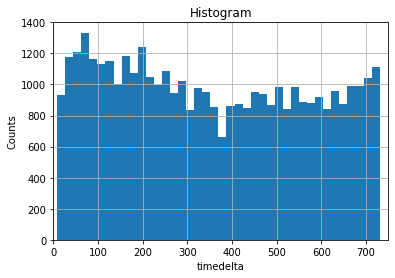

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [ ]:
# timedelta, exploration: 
#   > days between the article publication and the dataset acquisition
#   > Determine if values less than 3 weeks (21 days) are outliers.

# histogram
onp_df['timedelta'].hist(bins = 40)
plt.xlabel('timedelta')
plt.ylabel('Counts')
plt.title('Histogram')
plt.xlim(0, 750)
plt.ylim(0, 1400)
plt.grid(True)
plt.show()

# look at start of list for unique sorted values
timedelta_sorted = onp_df['timedelta'].sort_values()
timedelta_sorted.unique()[0:14]

timedelta, insight and decision: 
*   Even though the authors claimed that they discarded very recent articles (less than 3 weeks (21 days) old), they actually included articles with timedelta less than 21 days and these are not outliers. 
*   There is no reason we should clean or exclude any of these timedelta values.

Explore column n_tokens_content:

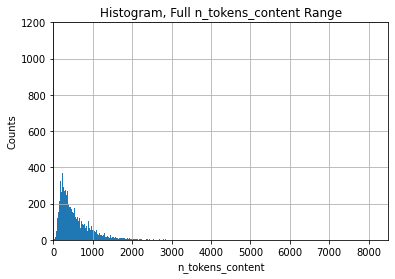

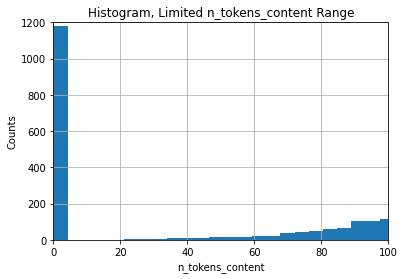

The percentage of rows that have n_tokens_content == 0 is 2.98%.
These are some the URLs for articles that have 0 words in the content:


893     http://mashable.com/2013/01/23/actual-facebook...
917     http://mashable.com/2013/01/23/fitness-gadget-...
1062    http://mashable.com/2013/01/25/data-vs-nature-...
1121    http://mashable.com/2013/01/26/infographics-ma...
1312    http://mashable.com/2013/01/29/social-tv-chart...
Name: url, dtype: object

In [ ]:
# n_tokens_content, exploration:
#   > number of words in the content
#   > Determine how common the 0s are and if we can remove them.

# histogram (full x range)
n_hist, bins_hist, patches_hist = plt.hist(onp_df['n_tokens_content'], bins = 2000)
plt.xlabel('n_tokens_content')
plt.ylabel('Counts')
plt.title('Histogram, Full n_tokens_content Range')
plt.xlim(0, 8500)
plt.ylim(0, 1200)
plt.grid(True)
plt.show()

# histogram (limited x range)
plt.hist(onp_df['n_tokens_content'], bins = 2000)
plt.xlabel('n_tokens_content')
plt.ylabel('Counts')
plt.title('Histogram, Limited n_tokens_content Range')
plt.xlim(0, 100)
plt.ylim(0, 1200)
plt.grid(True)
plt.show()

# limit the DataFrame to rows with n_tokens_content == 0
onp_df_n_tokens_content_0 = onp_df.loc[onp_df['n_tokens_content'] == 0]

# determine the percentage of rows that have n_tokens_content == 0
perc_n_tokens_content_0 = onp_df_n_tokens_content_0.shape[0]/onp_df.shape[0]*100
print('The percentage of rows that have n_tokens_content == 0 is {0:3.2f}%.'.format(perc_n_tokens_content_0))

print('These are some the URLs for articles that have 0 words in the content:')
onp_df_n_tokens_content_0['url'][0:5]

n_tokens_content, insight and decision:
*   There are a noticeable number of outliers with n_tokens_content == 0 meaning the articles have no content.
*   The 0s make up ~3% of the total number of rows in the DataFame.
*   Unfortunately, the URLs no longer work, so we have to assume that these articles had no content for some reason, and thus it is not clear what they are. Some have 0 images and videos as well, so they are not necessarily just images or videos with no text.
*   We will remove these rows from the dataset.

In [ ]:
# Exclude rows with n_tokens_content == 0
onp_df = onp_df.loc[onp_df['n_tokens_content'] > 0]

Explore average_token_length:



In [ ]:
# average_token_length, exploration:
#   > average length of the words in the content (average number of letters)
#   > Determine how common the 0s are and if we can remove them.

# Determine if there are still 0s present.
onp_df['average_token_length'].min()

3.6

average_token_length, insight and decision:
*   There are no longer any 0s after addressing the 0s in n_tokens_content, so no changes are needed.

Explore n_non_stop_words:

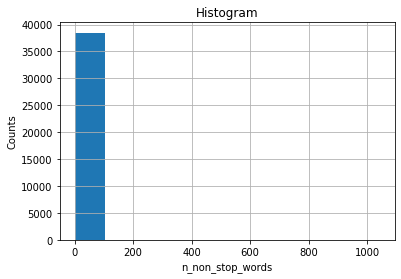

count    38463.000000
mean         1.027065
std          5.307978
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1042.000000
Name: n_non_stop_words, dtype: float64


31037    1042.0
29335       1.0
14120       1.0
9853        1.0
15101       1.0
38638       1.0
6297        1.0
2181        1.0
30187       1.0
Name: n_non_stop_words, dtype: float64

In [ ]:
# n_non_stop_words, exploration:
#   > rate of non-stop words in the content
#   > Why are there 0s and why is the maximum 1042 if this is supposed to be a 
#     rate?

# histogram
plt.hist(onp_df['n_non_stop_words'])
plt.xlabel('n_non_stop_words')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['n_non_stop_words'].describe())

# look at start of list for sorted values
n_non_stop_words_sorted = onp_df['n_non_stop_words'].sort_values(ascending = False)
n_non_stop_words_sorted[0:9]

n_non_stop_words, insight and decision
*   There are no longer any 0s after addressing the 0s in n_tokens_content.
*   There is a single outlier at 1042, and this row will be removed.

In [ ]:
# Exclude rows with n_non_stop_words == 1042
onp_df = onp_df.loc[onp_df['n_non_stop_words'] != 1042]

Explore n_unique_tokens:

In [ ]:
# n_unique_tokens, exploration: 
#   > rate of unique words in the content
#   > Why are there 0s, and why is the maximum 701 if this is supposed to be a 
#     rate? There should not be more unique words than overall words.

print(onp_df['n_unique_tokens'].describe())

count    38462.000000
mean         0.546837
std          0.102314
min          0.114964
25%          0.477419
50%          0.542982
75%          0.611111
max          1.000000
Name: n_unique_tokens, dtype: float64


n_unique_tokens, insight and decision:
*   The range of values is now > 0 and <= 1, which is acceptable, so no changes are needed.



Explore n_non_stop_unique_tokens:

In [ ]:
#   > rate of unique non-stop words in the content
#   > Why are there 0s, and why is the maximum 650 if this is supposed to be a 
#     rate?

print(onp_df['n_non_stop_unique_tokens'].describe())

count    38462.000000
mean         0.693455
std          0.100644
min          0.119134
25%          0.632588
50%          0.693727
75%          0.756944
max          1.000000
Name: n_non_stop_unique_tokens, dtype: float64


n_non_stop_unique_tokens, insight and decision:
*   The range of values is now > 0 and <= 1, which is acceptable, so no changes are needed.

Explore num_hrefs:

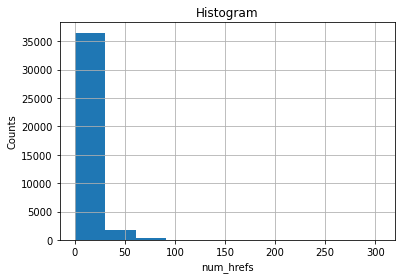

count    38462.000000
mean        11.217877
std         11.340728
min          0.000000
25%          5.000000
50%          8.000000
75%         14.000000
max        304.000000
Name: num_hrefs, dtype: float64


39338    304
17709    187
38174    186
3859     171
23473    162
37743    161
22697    159
23472    158
23441    153
Name: num_hrefs, dtype: int64

In [ ]:
# num_hrefs, exploration:
#   > number of links
#   > Why is the number of links as large as 304?

# histogram
plt.hist(onp_df['num_hrefs'])
plt.xlabel('num_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['num_hrefs'].describe())

# look at start of list for sorted values
num_hrefs_sorted = onp_df['num_hrefs'].sort_values(ascending = False)
num_hrefs_sorted[0:9]

num_hrefs, insight and decision:
*   There is a single outlier at 304, and this row will be removed.
*   The next largest number of links is 187, which seems unexpectedly large, but from there to lower values are not disconnected outliers.

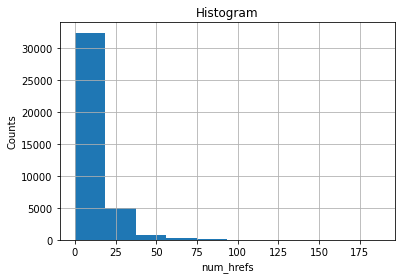

In [ ]:
# Exclude rows with num_hrefs == 304
onp_df = onp_df.loc[onp_df['num_hrefs'] != 304]

# histogram
plt.hist(onp_df['num_hrefs'])
plt.xlabel('num_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

Explore num_self_hrefs:

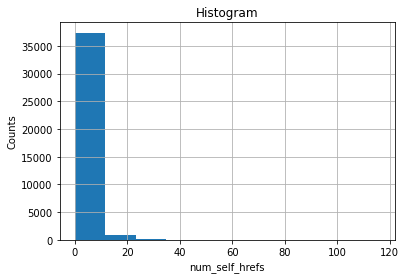

count    38461.000000
mean         3.394530
std          3.869704
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max        116.000000
Name: num_self_hrefs, dtype: float64


34418    116
4970      74
39159     65
4606      63
4264      63
2385      63
18447     62
13354     60
18225     56
Name: num_self_hrefs, dtype: int64

In [ ]:
# num_self_hrefs: 
#   > number of links to other articles published by Mashable (articles often
#     reference other articles previously published by Mashable)
#   > Why is the number of links as large as 116?

# histogram
plt.hist(onp_df['num_self_hrefs'])
plt.xlabel('num_self_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['num_self_hrefs'].describe())

# look at start of list for sorted values
num_self_hrefs_sorted = onp_df['num_self_hrefs'].sort_values(ascending = False)
num_self_hrefs_sorted[0:9]

num_self_hrefs, insight and decision:
*   There is a single outlier at 116, and this row will be removed.
*   The next largest number of links is 74, which seems unexpectedly large, but from there to lower values are not disconnected outliers, so the remaining values will be retained.

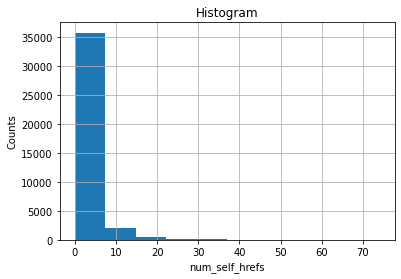

In [ ]:
# Exclude rows with num_self_hrefs == 116
onp_df = onp_df.loc[onp_df['num_self_hrefs'] != 116]

# histogram
plt.hist(onp_df['num_self_hrefs'])
plt.xlabel('num_self_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

Explore num_imgs:

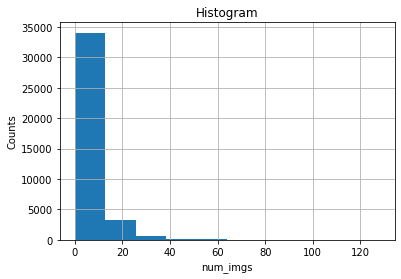

count    38460.000000
mean         4.561674
std          8.292118
min          0.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        128.000000
Name: num_imgs, dtype: float64


18702    128
24612    111
24802    111
24564    108
17891    101
24973    101
17857    100
24964    100
31901    100
Name: num_imgs, dtype: int64

In [ ]:
# num_imgs, exploration
#   > number of images
#   > Why is the number of images as large as 128?

# histogram
plt.hist(onp_df['num_imgs'])
plt.xlabel('num_imgs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['num_imgs'].describe())

# look at start of list for sorted values
num_imgs_sorted = onp_df['num_imgs'].sort_values(ascending = False)
num_imgs_sorted[0:9]

num_imgs, insight and decision
*   The maximum of 128, seems unexpectedly large, but it is not a clear disconnected outlier, so we will not do anything here.

Explore num_videos:

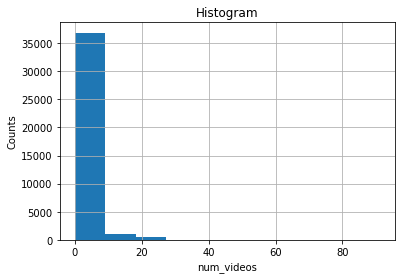

count    38460.000000
mean         1.263885
std          4.165043
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         91.000000
Name: num_videos, dtype: float64


18101    91
19706    75
1666     75
12642    74
3446     74
3011     74
12667    74
1615     74
1853     73
Name: num_videos, dtype: int64

In [ ]:
# num_videos, exploration
#   > number of videos
#   > Why is the number of videos as large as 91?

# histogram
plt.hist(onp_df['num_videos'])
plt.xlabel('num_videos')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['num_videos'].describe())

# look at start of list for sorted values
num_videos_sorted = onp_df['num_videos'].sort_values(ascending = False)
num_videos_sorted[0:9]

num_videos, insight and decision:
*   The maximum of 91, seems unexpectedly large, but it is not a clear disconnected outlier, so we will not do anything here.

Explore kw_min_min:

The percentage of rows that have kw_min_min == -1 is 56.97%.
count    38460.000000
mean        26.710348
std         70.280530
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          4.000000
max        377.000000
Name: kw_min_min, dtype: float64


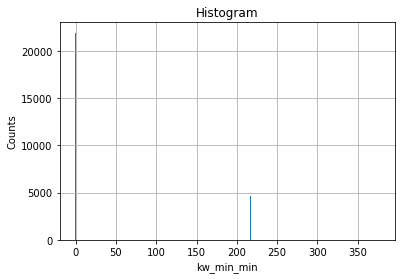

In [ ]:
# kw_min_min, exploration:
#   > worst keyword (min. shares)
#   > Why are there so many values of -1?

# determine the percentage of rows that have kw_min_min == -1
# limit the DataFrame to rows with kw_min_min == -1
onp_df_kw_min_min_neg1 = onp_df.loc[onp_df['kw_min_min'] == -1]
perc_kw_min_min_neg1 = onp_df_kw_min_min_neg1.shape[0]/onp_df.shape[0]*100
print('The percentage of rows that have kw_min_min == -1 is {0:3.2f}%.'.format(perc_kw_min_min_neg1))

print(onp_df['kw_min_min'].describe())

# histogram
plt.hist(onp_df['kw_min_min'], bins = 500)
plt.xlabel('kw_min_min')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

kw_min_min, insight and decision:
*   The authors of the dataset made some kind of error here in producing a negative number of shares. We cannot reject 56.97% of the data.

Explore kw_avg_min:

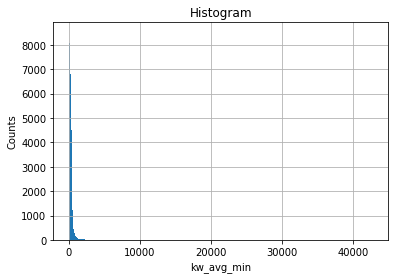

count    38460.000000
mean       313.957423
std        624.472400
min         -1.000000
25%        143.000000
50%        237.600000
75%        359.200000
max      42827.857140
Name: kw_avg_min, dtype: float64


In [ ]:
# kw_avg_min, exploration:
#   > worst keyword (avg. shares)
#   > Why are there values of -1?

# histogram
plt.hist(onp_df['kw_avg_min'], bins = 500)
plt.xlabel('kw_avg_min')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['kw_avg_min'].describe())

kw_avg_min, insight and decision:
*   The authors of the dataset made some kind of error here in producing a negative number of shares.

Explore kw_min_avg:

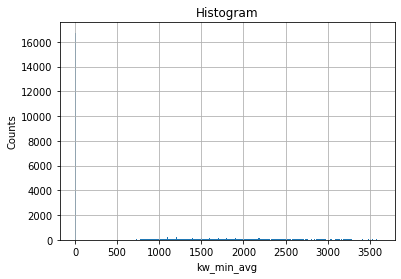

count    38460.000000
mean      1101.914250
std       1127.022035
min         -1.000000
25%          0.000000
50%       1008.450030
75%       2031.021739
max       3613.039820
Name: kw_min_avg, dtype: float64


In [ ]:
# kw_min_avg, exploration:
#   > avg. keyword (min. shares)

# histogram
plt.hist(onp_df['kw_min_avg'], bins = 500)
plt.xlabel('kw_min_avg')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(onp_df['kw_min_avg'].describe())

kw_min_avg, insight and decision:
*   The authors of the dataset made some kind of error here in producing a negative number of shares.

We cannot get rid of the whole set of kw_min/avg/max_min/avg/max variables because the authors determined that kw_avg_avg and kw_max_avg are the two most important features. It appears that there error was to subtract an extra 1 for some reason, perhaps they accounted for the current article incorrectly. Therefore, in order to retain these features we add 1 to each of them.

In [ ]:
onp_df['kw_min_min'] = onp_orig_df['kw_min_min'] + 1
onp_df['kw_avg_min'] = onp_orig_df['kw_avg_min'] + 1
onp_df['kw_max_min'] = onp_orig_df['kw_max_min'] + 1
onp_df['kw_min_avg'] = onp_orig_df['kw_min_avg'] + 1
onp_df['kw_avg_avg'] = onp_orig_df['kw_avg_avg'] + 1
onp_df['kw_max_avg'] = onp_orig_df['kw_max_avg'] + 1
onp_df['kw_min_max'] = onp_orig_df['kw_min_max'] + 1
onp_df['kw_avg_max'] = onp_orig_df['kw_avg_max'] + 1
onp_df['kw_max_max'] = onp_orig_df['kw_max_max'] + 1

Explore title_subjectivity:

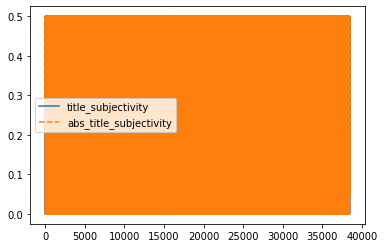

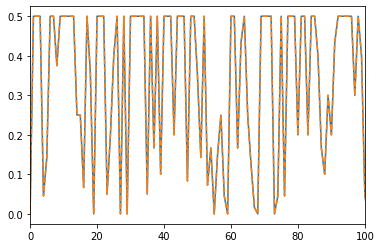

-1.3877787807814457e-16
1.1102230246251565e-16


In [ ]:
# title_subjectivity, exploration:
#   > Determine if title_subjectivity and abs_title_subjectivity are essentially 
#     the same.
#   > The expectation is that abs_title_subjectivity = |title_subjectivity - 0.5|

row_np_array = np.arange(len(onp_df['title_subjectivity']))
plt.plot(row_np_array, abs(onp_df['title_subjectivity']-0.5), label = 'title_subjectivity', linestyle="-")
plt.plot(row_np_array, onp_df['abs_title_subjectivity'], label = 'abs_title_subjectivity', linestyle="--")
plt.legend()
plt.show()

plt.plot(row_np_array, abs(onp_df['title_subjectivity']-0.5), label = 'title_subjectivity', linestyle="-")
plt.plot(row_np_array, onp_df['abs_title_subjectivity'], label = 'abs_title_subjectivity', linestyle="--")
plt.xlim(0, 100)
plt.show()

print(min(onp_df['abs_title_subjectivity'] - abs(onp_df['title_subjectivity']-0.5)))
print(max(onp_df['abs_title_subjectivity'] - abs(onp_df['title_subjectivity']-0.5)))

title_subjectivity, insight and decision:
*   Drop abs_title_subjectivity because based on the above, it and title_subjectivity are identical except for the shift by 0.5 and absolute value and so both are not needed.

In [ ]:
onp_df = onp_df.drop(columns=['abs_title_subjectivity'])

Explore title_sentiment_polarity:

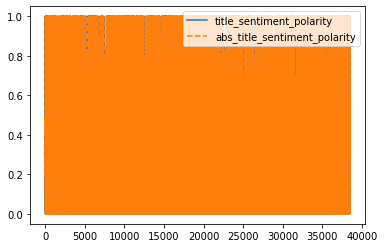

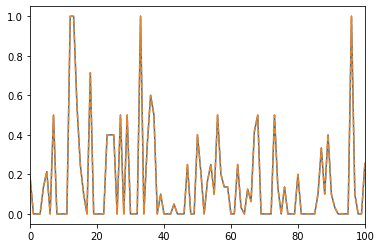

0.0
0.0


In [ ]:
# title_sentiment_polarity, exploration:
#   > title polarity
#   > Determine if title_sentiment_polarity and abs_title_sentimental_polarity 
#     are essentially the same.
#   > The expectation is that abs_title_sentiment_polarity = |title_sentiment_polarity|.

row_np_array = np.arange(len(onp_df['title_sentiment_polarity']))
plt.plot(row_np_array, abs(onp_df['title_sentiment_polarity']), label = 'title_sentiment_polarity', linestyle="-")
plt.plot(row_np_array, onp_df['abs_title_sentiment_polarity'], label = 'abs_title_sentiment_polarity', linestyle="--")
plt.legend()
plt.show()

plt.plot(row_np_array, abs(onp_df['title_sentiment_polarity']), label = 'title_sentiment_polarity', linestyle="-")
plt.plot(row_np_array, onp_df['abs_title_sentiment_polarity'], label = 'abs_title_sentiment_polarity', linestyle="--")
plt.xlim(0, 100)
plt.show()

print(min(onp_df['abs_title_sentiment_polarity'] - abs(onp_df['title_sentiment_polarity'])))
print(max(onp_df['abs_title_sentiment_polarity'] - abs(onp_df['title_sentiment_polarity'])))

title_sentiment_polarity, insight and decision:
*   Drop abs_title_sentiment_polarity because based on the above, it and title_sentiment_polarity are identical except for the absolute value and so both are not needed.

In [ ]:
onp_df = onp_df.drop(columns=['abs_title_sentiment_polarity'])

Let us do some exploration of the target outcome, the number of shares:

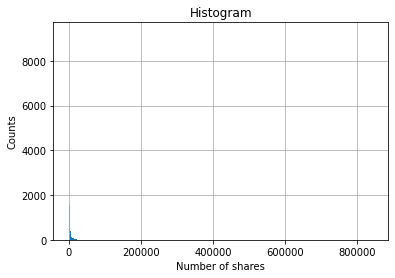

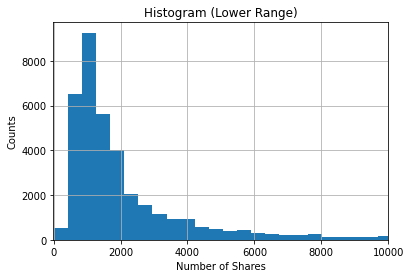

In [ ]:
# histogram of shares
n_hist_s, bins_hist_s, patches_hist_s = plt.hist(onp_df['shares'], bins = 2000)
plt.xlabel('Number of shares')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

#print(bins_hist_s[0:9])
#print(n_hist_s[0:9])

# histogram of shares limited to lower range
plt.hist(onp_df['shares'], bins = 2000)
plt.xlim(-10, 10000)
plt.xlabel('Number of Shares')
plt.ylabel('Counts')
plt.title('Histogram (Lower Range)')
plt.grid(True)
plt.show()

shares_per_day:
*   The number of shares is clearly not normally distributed. Most articles have a small number of shares, but then the maximum number of shares extends all the way to 843,300. There is a very long tail.

Remove the 'url' and 'timedelta' columns because we will not be using them below.


In [ ]:
# remove url and timedelta
onp_df = onp_df.drop(columns=['url', 'timedelta'])

Do a final look at summary statistics of the remaining DataFrame to confirm that the cleaning was successful:

In [ ]:
# summary statistics of cleaned data
onp_df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,shares
count,38460.000000,38460.000000,38460.000000,3.846000e+04,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000,38460.000000
mean,10.382449,563.235153,0.546846,1.000000e+00,0.693470,11.207462,3.391602,4.561674,1.263885,4.687845,7.214925,0.054004,0.178211,0.162116,0.060088,0.190432,0.212376,27.710348,1152.794793,314.957423,13182.748570,750311.252210,255214.684895,1102.914250,5604.823167,3104.403781,4121.649269,10646.828049,6598.330360,0.168253,0.186401,0.187337,0.183359,0.143968,0.061596,0.069085,0.130681,0.188147,0.141668,0.217193,0.214301,0.238691,0.456997,0.122977,0.040844,0.017123,0.703113,0.296783,0.364703,0.098377,0.779992,-0.267500,-0.537986,-0.110803,0.280574,0.070992,3355.247712
std,2.113867,468.264220,0.102297,4.028147e-09,0.100608,11.228879,3.826916,8.292118,4.165043,0.283104,1.916477,0.226029,0.382695,0.368562,0.237654,0.392647,0.408995,70.280530,3870.642056,624.472400,56852.536835,216402.769809,131825.486973,1127.022035,6096.945015,1301.282579,20027.556357,41613.729347,24554.789989,0.374095,0.389435,0.390187,0.386966,0.351062,0.240424,0.253602,0.337056,0.265553,0.220332,0.282244,0.288945,0.291378,0.088358,0.096092,0.016227,0.010588,0.150171,0.150030,0.085434,0.070381,0.212475,0.121170,0.279691,0.094920,0.323556,0.264343,11586.400227
min,2.000000,18.000000,0.114964,9.999999e-01,0.119134,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.018182,0.018182,0.018182,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000
25%,9.000000,259.000000,0.477419,1.000000e+00,0.632588,5.000000,1.000000,1.000000,0.000000,4.496241,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,446.000000,144.000000,1.000000,843301.000000,171301.000000,1.000000,3550.290325,2374.793125,703.000000,1200.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025061,0.025012,0.028572,0.025622,0.028575,0.402458,0.064394,0.029466,0.010178,0.612903,0.200000,0.311883,0.050000,0.600000,-0.331548,-0.714286,-0.125000,0.000000,0.000000,945.000000
50%,10.000000,423.000000,0.542982,1.0

The ranges of all the columns are now acceptable, so the cleaning was successful.

####**Task 3**
**Model the outcome of interest.** We should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power, and experiment with both.

The outcome we are interested in is 'shares', which is the number of shares of each article (row) on a variety of social media platforms. 

Because the outcome 'shares' is numerical, the models we intially attemtped were regression models. We looked at regression models we have leared about in this course: (1) linear regression, (2) decision tree, and (3) random forest. They all performed poorly even though they were explored fairly exhaustively while trying the following steps:
*   (1) ordinary least squares (OLS) linear regression
  *   applied logarithmic transformations to variables with large skewness: some features and outcome 'shares'
  *   excluded feature 'is_weekend', because it is sum of other features 'is_saturday' and 'is_sunday'
  *   if pair of features had correlation above specified threshold, excluded one of the features, and tested the threshold
  *   removed features with insignificant coefficients until there were only significant ones remaining
  *   the optimal OLS model (at a feature correlation threshold of 0.8) had an R-squared of 0.117 for the training data and 0.107 for the test data.
*   (2) decision tree regression
  *   tried without and with logarithmic transformations
  *   excluded sparse features: weekday_is_\* and data_channel_is_\*
  *   adjusted parameters in DecisionTreeRegressor: max_depth, max_features, and min_samples_leaf
  *   the coefficient of determination score returned was typically negative, and went slightly above 0.0 with changes to min_samples_leaf and max_depth, which indicates the model disregards the features, and it was never anywhere close to the best possible score of 1.0.  
*   (3) random forest regression
  *   tried without and with logarithmic transformations
  *   excluded sparse features: weekday_is_\* and data_channel_is_\*
  *   RandomForestRegressor produced negative scores with the default parameters, and it is hard to imagine random forest working if decision tree does not.

Because all attempts at regression modeling did not work, we now use classification modeling by following what the authors of the original dataset and article (referenced above) did with the outcome 'shares'. They changed 'shares' from a numerical variable to a binary classification variable, and we will do the same. The median 'shares' is 1400, so values less than 1400 are set to 0 for unpopular and values greater than or equal to 1400 are set to 1 for popular.

In [ ]:
# median shares
onp_df['shares'].median()

1400.0

In [ ]:
# convert shares from number to binary classification
onp_df['shares_class'] = 0
onp_df.loc[onp_df['shares'] >= onp_df['shares'].median(),'shares_class'] = 1

In [ ]:
# confirm the above classification by checking example rows
#onp_df.loc[:,['shares', 'shares_class']].iloc[0:20]

Remove column n_non_stop_words, because its standard deviation (4.028147e-09) is extremely small relative to its mean (1.000000). That is, it is essentially constant and would not contribute anything to any type of model.

In [ ]:
# remove n_non_stop_words
onp_df = onp_df.drop(columns=['n_non_stop_words'])

Column is_weekend is the sum of columns weekday_is_saturday and weekday_is_sunday, because they are exclusive. There does not seem be any reason to retain all of these, and one feature being a linear combination of the others may be detrimental to at least some of the modeling below. Thus, is_weekend is removed. There are no other columns that are apparent exact linear combination of others.

In [ ]:
# determine if is_weekend can be expressed as an exact linear combination
# of weekday_is_saturday and weekday_is_sunday 
ftr_is_weekend = onp_df['is_weekend']
ftr_sum_is_saturday_is_sunday = onp_df['weekday_is_saturday'] + onp_df['weekday_is_sunday']

print(min(ftr_is_weekend))
print(max(ftr_is_weekend))
print(min(ftr_sum_is_saturday_is_sunday))
print(max(ftr_sum_is_saturday_is_sunday))
print(min(ftr_is_weekend - ftr_sum_is_saturday_is_sunday))
print(max(ftr_is_weekend - ftr_sum_is_saturday_is_sunday))

# remove is_weekend
onp_df = onp_df.drop(columns=['is_weekend'])

0
1
0
1
0
0


We apply logarithmic transformations to features that are unbound and have a highly skewed distribution. In the previous modeling effort, using regression, we found that applying logarithmic transformations in this way provided some performance benefit, and did not seem to have a downside. This is similar to what the authors of the original dataset and article did; they applied logarithmic transformations to all unbound features, even ones with small skewness, which does not seem necessary.

First, we have to identify the variables to which we want to apply the transformation. Therefore, we look at the distribution of all unbounded variables:
*   n_tokens_title
*   n_tokens_content
*   num_hrefs
*   num_self_hrefs
*   num_imgs
*   num_videos
*   average_token_length
*   num_keywords
*   kw_min_min
*   kw_max_min
*   kw_avg_min
*   kw_min_max
*   kw_max_max
*   kw_avg_max
*   kw_min_avg
*   kw_max_avg
*   kw_avg_avg
*   self_reference_min_shares
*   self_reference_max_shares
*   self_reference_avg_shares

n_tokens_title:

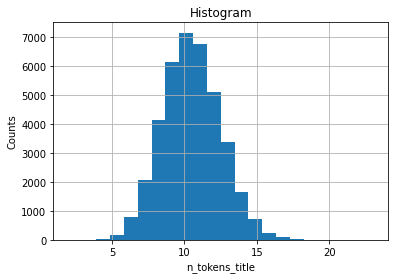

DescribeResult(nobs=38460, minmax=(2, 23), mean=10.382449297971919, variance=4.468435301909333, skewness=0.1711085526599277, kurtosis=0.011627358746648664)


In [ ]:
# histogram
plt.hist(onp_df['n_tokens_title'], bins = 22)
plt.xlabel('n_tokens_title')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['n_tokens_title']))

The skewness is not large here, so we will not apply a transformation to n_tokens_title.

n_tokens_content:

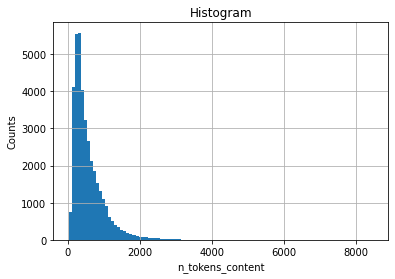

DescribeResult(nobs=38460, minmax=(18, 8474), mean=563.2351534061362, variance=219271.37989216036, skewness=3.0328213314714643, kurtosis=20.23689342078025)


In [ ]:
# histogram
plt.hist(onp_df['n_tokens_content'], bins = 100)
plt.xlabel('n_tokens_content')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['n_tokens_content']))

The skewness is large here (>3), so we will apply a transformation to n_tokens_content. 

num_hrefs:

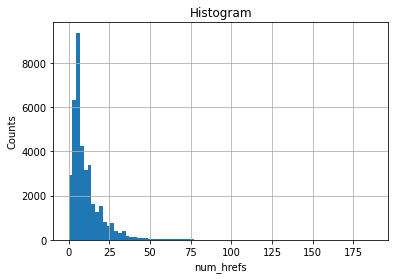

DescribeResult(nobs=38460, minmax=(0, 187), mean=11.20746229849194, variance=126.08772090590844, skewness=3.7076621449661453, kurtosis=25.408834844842467)


In [ ]:
# histogram
plt.hist(onp_df['num_hrefs'], bins = 80)
plt.xlabel('num_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['num_hrefs']))

The skewness is large here (>3), so we will apply a transformation to num_hrefs.

num_self_hrefs:

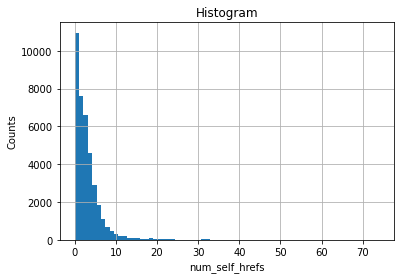

DescribeResult(nobs=38460, minmax=(0, 74), mean=3.3916016640665627, variance=14.64528685970757, skewness=4.729047816516579, kurtosis=39.73770299322663)


In [ ]:
# histogram
plt.hist(onp_df['num_self_hrefs'], bins = 70)
plt.xlabel('num_self_hrefs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['num_self_hrefs']))

The skewness is large here (>3), so we will apply a transformation to num_self_hrefs.



num_imgs:

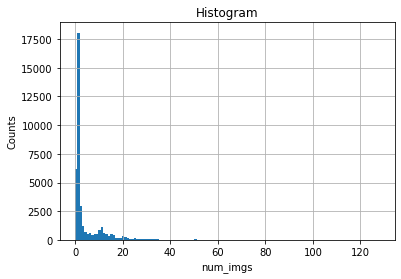

DescribeResult(nobs=38460, minmax=(0, 128), mean=4.561674466978679, variance=68.75921652056284, skewness=3.959172767928587, kurtosis=24.67381894367752)


In [ ]:
# histogram
plt.hist(onp_df['num_imgs'], bins = 130)
plt.xlabel('num_imgs')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['num_imgs']))

The skewness is large here (>3), so we will apply a transformation to num_imgs.

num_videos:

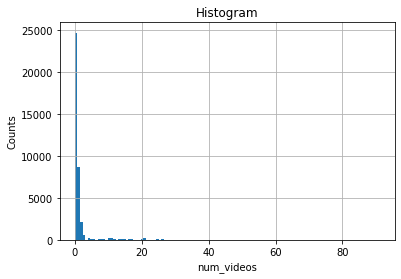

DescribeResult(nobs=38460, minmax=(0, 91), mean=1.2638845553822153, variance=17.34758666755313, skewness=6.924784576684589, kurtosis=72.04081631325192)


In [ ]:
# histogram
plt.hist(onp_df['num_videos'], bins = 120)
plt.xlabel('num_videos')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['num_videos']))

The skewness is large here (>3), so we will apply a transformation to num_videos.

avg_token_length:

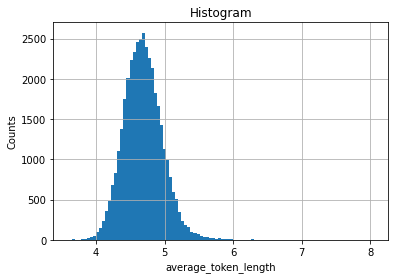

DescribeResult(nobs=38460, minmax=(3.6, 8.041533546), mean=4.68784473121313, variance=0.0801477598908023, skewness=0.5718189946802236, kurtosis=2.5615191528851264)


In [ ]:
# histogram
plt.hist(onp_df['average_token_length'], bins = 100)
plt.xlabel('average_token_length')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['average_token_length']))

The skewness is not large here, so we will not apply a transformation to average_token_length.

num_keywords:

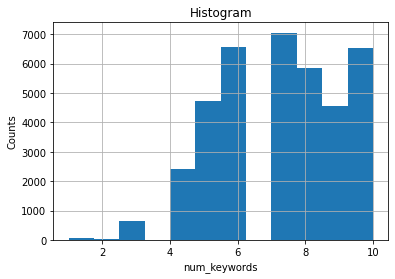

DescribeResult(nobs=38460, minmax=(1, 10), mean=7.214924596983879, variance=3.672883675637205, skewness=-0.14423455601178645, kurtosis=-0.8153645472255615)


In [ ]:
# histogram
plt.hist(onp_df['num_keywords'], bins = 12)
plt.xlabel('num_keywords')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['num_keywords']))

The skewness is not large here, so we will not apply a transformation to num_keywords.

kw_min_min:

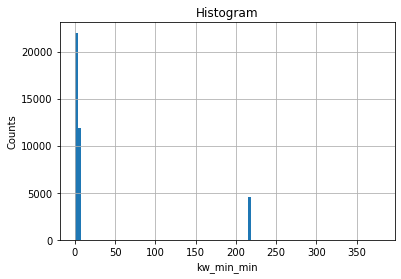

DescribeResult(nobs=38460, minmax=(0, 378), mean=27.710348413936558, variance=4939.352850602754, skewness=2.336522815021473, kurtosis=3.478452552858119)


In [ ]:
# histogram
plt.hist(onp_df['kw_min_min'], bins = 100)
plt.xlabel('kw_min_min')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_min_min']))

The skewness is not technically large here (< 3), so we would normally not apply a transformation to kw_min_min, but let us look at the rest of the "kw" set first.

kw_max_min:

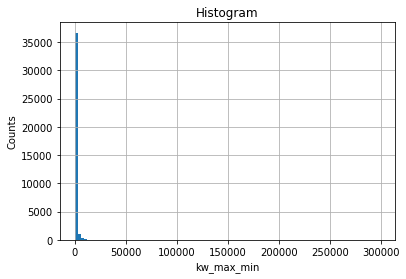

DescribeResult(nobs=38460, minmax=(1.0, 298401.0), mean=1152.7947930317214, variance=14981869.928700952, skewness=35.84101428028823, kurtosis=2133.9236155665862)


In [ ]:
# histogram
plt.hist(onp_df['kw_max_min'], bins = 100)
plt.xlabel('kw_max_min')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_max_min']))

The skewness is large here (>3), so we will apply a transformation to kw_max_min.

kw_avg_min:

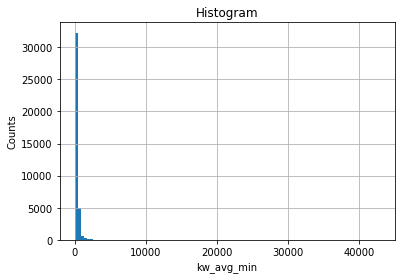

DescribeResult(nobs=38460, minmax=(0.0, 42828.85714), mean=314.9574227833769, variance=389965.7786720152, skewness=31.563682780339885, kurtosis=1601.0676880909816)


In [ ]:
# histogram
plt.hist(onp_df['kw_avg_min'], bins = 100)
plt.xlabel('kw_avg_min')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_avg_min']))

The skewness is large here (>3), so we will apply a transformation to kw_avg_min.

kw_min_max:

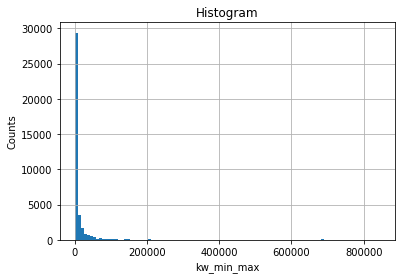

DescribeResult(nobs=38460, minmax=(1, 843301), mean=13182.748569942798, variance=3232210944.6054416, skewness=10.593937440083465, kurtosis=128.1024012383226)


In [ ]:
# histogram
plt.hist(onp_df['kw_min_max'], bins = 100)
plt.xlabel('kw_min_max')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_min_max']))

The skewness is large here (>3), so we will apply a transformation to kw_min_max.

kw_max_max:

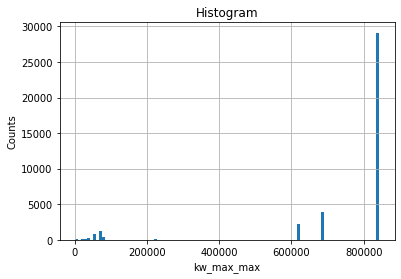

DescribeResult(nobs=38460, minmax=(1, 843301), mean=750311.2522100884, variance=46830158781.235954, skewness=-2.606072172880525, kurtosis=5.508386060447403)


In [ ]:
# histogram
plt.hist(onp_df['kw_max_max'], bins = 100)
plt.xlabel('kw_max_max')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_max_max']))

The absolute skewness is not technically large here (< 3), so we would normally not apply a transformation to kw_max_max, but the data appear to have a large range with a tail to the left, and let us look at the rest of the "kw" set first.

kw_avg_max:

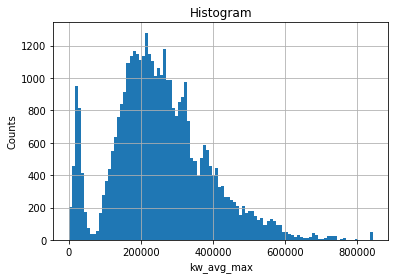

DescribeResult(nobs=38460, minmax=(1.0, 843301.0), mean=255214.6848953618, variance=17377959015.636, skewness=0.5993427738268052, kurtosis=0.8862114802095036)


In [ ]:
# histogram
plt.hist(onp_df['kw_avg_max'], bins = 100)
plt.xlabel('kw_avg_max')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_avg_max']))

The skewness is not large here, so we would normally not apply a transformation to kw_avg_max, but let us look at the rest of the "kw" set first.

kw_min_avg:

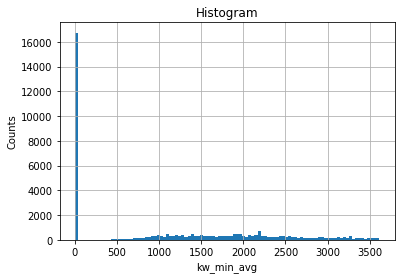

DescribeResult(nobs=38460, minmax=(0.0, 3614.0398200000004), mean=1102.9142498282474, variance=1270178.6669450954, skewness=0.4736682179707166, kurtosis=-1.1190740798510315)


In [ ]:
# histogram
plt.hist(onp_df['kw_min_avg'], bins = 100)
plt.xlabel('kw_min_avg')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_min_avg']))

The skewness is not technically large here (< 3), so we would normally not apply a transformation to kw_min_avg, but the data appear to have a large range with a tail to the right, and let us look at the rest of the "kw" set first.

kw_max_avg:

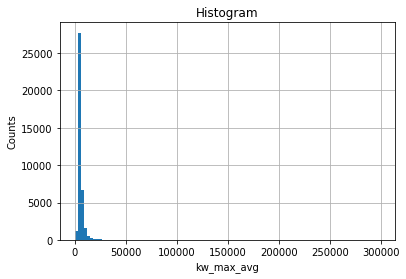

DescribeResult(nobs=38460, minmax=(1.0, 298401.0), mean=5604.823166729771, variance=37172738.51741645, skewness=16.629867159161876, kurtosis=492.2676609342395)


In [ ]:
# histogram
plt.hist(onp_df['kw_max_avg'], bins = 100)
plt.xlabel('kw_max_avg')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_max_avg']))

The skewness is large here (>3), so we will apply a transformation to kw_max_avg.

kw_avg_avg:

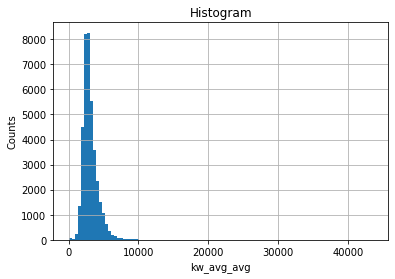

DescribeResult(nobs=38460, minmax=(1.0, 43568.65995), mean=3104.403781389218, variance=1693336.351286013, skewness=6.07019381101067, kurtosis=108.82697489406372)


In [ ]:
# histogram
plt.hist(onp_df['kw_avg_avg'], bins = 100)
plt.xlabel('kw_avg_avg')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['kw_avg_avg']))

The skewness is large here (>3), so we will apply a transformation to kw_avg_avg.

Of the "kw" variables, 5 of 9 have absolute skewness > 3, indicating that we should apply a transformation to them. Of the remaining 4 with skewness <= 3, 3 have something like a tail feature. For consistency, we will apply the same transformation to all of the "kw" variables.

self_reference_min_shares:

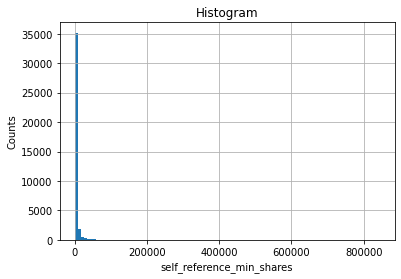

DescribeResult(nobs=38460, minmax=(0.0, 843300.0), mean=4121.649269370775, variance=401103013.6466273, skewness=25.89908777144382, kurtosis=840.3576931465882)


In [ ]:
# histogram
plt.hist(onp_df['self_reference_min_shares'], bins = 100)
plt.xlabel('self_reference_min_shares')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['self_reference_min_shares']))

The skewness is very large, so we will apply a transformation to self_reference_min_shares.

self_reference_max_shares:

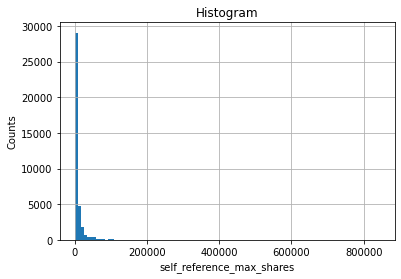

DescribeResult(nobs=38460, minmax=(0.0, 843300.0), mean=10646.828049141965, variance=1731702470.1525798, skewness=13.679225609734134, kurtosis=217.79285755659214)


In [ ]:
# histogram
plt.hist(onp_df['self_reference_max_shares'], bins = 100)
plt.xlabel('self_reference_max_shares')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['self_reference_max_shares']))

The skewness is very large, so we will apply a transformation to self_reference_max_shares.

self_reference_avg_shares:

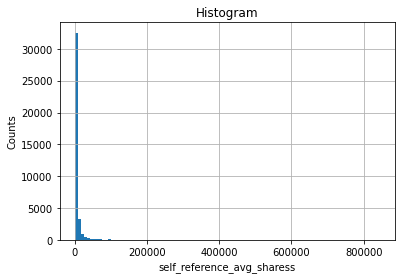

DescribeResult(nobs=38460, minmax=(0.0, 843300.0), mean=6598.330360016367, variance=602937711.4072981, skewness=17.677384367206383, kurtosis=416.7961543920561)


In [ ]:
# histogram
plt.hist(onp_df['self_reference_avg_sharess'], bins = 100)
plt.xlabel('self_reference_avg_sharess')
plt.ylabel('Counts')
plt.title('Histogram')
plt.grid(True)
plt.show()

print(stats.describe(onp_df['self_reference_avg_sharess']))

The skewness is very large, so we will apply a transformation to self_reference_avg_shares.

Based on the above we will apply transformations to these variables:
*   n_tokens_content (minimum = 18)
*   num_hrefs (minimum = 0)
*   num_self_hrefs (minimum = 0)
*   num_imgs (minimum = 0)
*   num_videos (minimum = 0)
*   kw_min_min (minimum = 0)
*   kw_max_min (minimum = 1)
*   kw_avg_min (minimum = 0)
*   kw_min_max (minimum = 1)
*   kw_max_max (minimum = 1)
*   kw_avg_max (minimum = 1)
*   kw_min_avg (minimum = 0)
*   kw_max_avg (minimum = 1)
*   kw_avg_avg (minimum = 1)
*   self_reference_min_shares (minimum = 0)
*   self_reference_max_shares (minimum = 0)
*   self_reference_avg_sharess (minimum = 0)

We apply a logarithmic transformation to these variables: x_new = log10(x+1). The +1 is needed to handle the 0s. Even though the +1 is not needed for some variables with minimums above 0, we still use it for those variables for consistency.

In [ ]:
onp_df_tfm = onp_df.copy()

# logarithmic transformations
onp_df_tfm['log_n_tokens_content'] = np.log10(onp_df['n_tokens_content']+1)
onp_df_tfm['log_num_hrefs'] = np.log10(onp_df['num_hrefs']+1)
onp_df_tfm['log_num_self_hrefs'] = np.log10(onp_df['num_self_hrefs']+1)
onp_df_tfm['log_num_imgs'] = np.log10(onp_df['num_imgs']+1)
onp_df_tfm['log_num_videos'] = np.log10(onp_df['num_videos']+1)
onp_df_tfm['log_kw_min_min'] = np.log10(onp_df['kw_min_min']+1)
onp_df_tfm['log_kw_max_min'] = np.log10(onp_df['kw_max_min']+1)
onp_df_tfm['log_kw_avg_min'] = np.log10(onp_df['kw_avg_min']+1)
onp_df_tfm['log_kw_min_max'] = np.log10(onp_df['kw_min_max']+1)
onp_df_tfm['log_kw_max_max'] = np.log10(onp_df['kw_max_max']+1)
onp_df_tfm['log_kw_avg_max'] = np.log10(onp_df['kw_avg_max']+1)
onp_df_tfm['log_kw_min_avg'] = np.log10(onp_df['kw_min_avg']+1)
onp_df_tfm['log_kw_max_avg'] = np.log10(onp_df['kw_max_avg']+1)
onp_df_tfm['log_kw_avg_avg'] = np.log10(onp_df['kw_avg_avg']+1)
onp_df_tfm['log_self_reference_min_shares']  = np.log10(onp_df['self_reference_min_shares']+1)
onp_df_tfm['log_self_reference_max_shares']  = np.log10(onp_df['self_reference_max_shares']+1)
onp_df_tfm['log_self_reference_avg_sharess'] = np.log10(onp_df['self_reference_avg_sharess']+1)

# remove ones not using now
onp_df_tfm = onp_df_tfm.drop(columns=['n_tokens_content', 'num_hrefs', 
                                      'num_self_hrefs', 'num_imgs', 'num_videos',
                                      'kw_min_min', 'kw_max_min', 'kw_avg_min',
                                      'kw_min_max', 'kw_max_max', 'kw_avg_max',
                                      'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 
                                      'self_reference_min_shares', 
                                      'self_reference_max_shares', 
                                      'self_reference_avg_sharess'])

In [ ]:
#confirm changes
#onp_df_tfm.describe()

Set one random state setting to use throughout all modeling:

In [ ]:
# Choose one random state setting to use throughout all modeling
rs = 7

Separate out X (features) and y (outcome):

In [ ]:
X = onp_df_tfm.loc[:, ~onp_df_tfm.columns.isin(['shares', 'shares_class'])]
y = onp_df_tfm['shares_class']

Split data into training and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rs)

#####**Logistic Regression**
The first model we use is logistic regression, which finds the optimal linear boundaries separating the outcome variable classes. We start again with the full DataFrame instead of the training and test sets, because optimizing logistic regression requires additional preprocessing steps.

The first step we take is to investigate how correlated the features are with each other, and when a feature pair exceeds a specified correlation threshold, exclude one of the features from modeling. Make a correlation matrix for the features.

In [ ]:
# absolute correlation matrix
onp_features_df = onp_df_tfm.loc[:, ~onp_df_tfm.columns.isin(['shares', 'shares_class'])]
abs_corr_matrix_features = onp_features_df.corr().abs()

View the absolute correlation matrix with a heatmap.

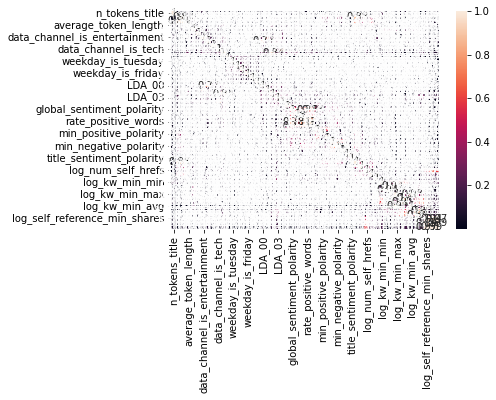

In [ ]:
# heatmap
sn.heatmap(abs_corr_matrix_features, annot=True)
plt.show()

With the large number of features (54), it is not possible to resolve individual correlations in the heatmap, so instead we form a DataFrame with the absolute correlations sorted in descending order, to see how highly correlated some features are.

In [ ]:
# extract feature names
features_np_arr = np.array(onp_features_df.columns)

# define empty DataFrame
features_abs_correlations = pd.DataFrame(columns = ['feature_1', 'feature_2', 
                                                    'abs_correlation'])

# fill data DataFrame with absolute correlations and paired names of features 
for i in range(features_np_arr.size):
  for j in range(features_np_arr.size):
    features_abs_correlations = features_abs_correlations.append({'feature_1': features_np_arr[i], 
                                                                  'feature_2': features_np_arr[j], 
                                                                  'abs_correlation': abs_corr_matrix_features.iloc[i,j]}, 
                                                                 ignore_index = True)

# sort
features_abs_correlations_sorted = features_abs_correlations.sort_values(by='abs_correlation', ascending=False)

# select absolute correlations to look at (leave out autocorrelations which are 
# 1 and only every other row after that because of mirror image across 
# autocorrelation line)
features_abs_correlations_sorted_sel = features_abs_correlations_sorted.iloc[len(features_np_arr)+1::2,:]

In [ ]:
features_abs_correlations_sorted_sel[0:19]

,feature_1,feature_2,abs_correlation
1486,rate_positive_words,rate_negative_words,0.997693
2861,log_self_reference_max_shares,log_self_reference_avg_sharess,0.993977
2478,log_kw_min_max,log_kw_min_avg,0.982953
2807,log_self_reference_min_shares,log_self_reference_avg_sharess,0.966860
2419,log_kw_avg_min,log_kw_max_min,0.944365
2859,log_self_reference_max_shares,log_self_reference_min_shares,0.938316
2584,log_kw_avg_max,log_kw_max_max,0.908581
2696,log_kw_max_avg,log_kw_avg_avg,0.892042
109,n_non_stop_unique_tokens,n_unique_tokens,0.885136
1999,log_n_tokens_content,n_unique_tokens,0.883158


Setup the initial logistic regression model. In the earlier modeling attempt, when the outcome variable was numerical, we attempted to model this data with ordinary least squares linear, and found the best model occurred when max_abs_corr_features was set to 0.80, so we will start with that value while exploring the LogisticRegression parameters, and then come back to it later. The initial model will use the default parameters in LogisticRegresssion:
*   'solver': This is the algorithm to use in the optimization problem. The default is 'lbfgs' (Large-scale Bound-constrained Optimization), which is a more complex variation of the gradient descent algorithm.
*   'penalty': The penalty parameter controls regularization. Regularization is used to combat overfitting. Regularization has the effect of reducing the variance between coefficients. This means that the model does not fit the training data quite as well, but it should generalize to unseen data better. The default is 'l2', which adds a L2 penalty term.
*   'max_iter': This is the maximum number of iterations taken for the solvers to converge. The default is 100.




We set the threshold for absolute correlation at 0.8, and for the feature pairs that are above that threshold we remove feature_2.

In [ ]:
# *set threshold*
max_abs_corr_features = 0.80

cols_drop_high_abs_corr = features_abs_correlations_sorted_sel.loc[features_abs_correlations_sorted_sel['abs_correlation'] > max_abs_corr_features]['feature_2']

# remove features
onp_df_lgr = onp_df_tfm.copy()
onp_df_lgr = onp_df_lgr.drop(columns=cols_drop_high_abs_corr)

Separate out X_lgr (features) and y_lgr (outcome):

In [ ]:
X_lgr = onp_df_lgr.loc[:, ~onp_df_lgr.columns.isin(['shares', 'shares_class'])]
y_lgr = onp_df_lgr['shares_class']

We obtain a standard scale for the features optimize the logistic regression. Each feature is transformed by removing its mean and scaling it to a unit variance.

In [ ]:
scaler_lgr = StandardScaler()
X_lgr_scaled_ndarray = scaler_lgr.fit_transform(X_lgr)
X_lgr_scaled = pd.DataFrame(X_lgr_scaled_ndarray, columns = X_lgr.columns.values)

Split data into training and test sets:

In [ ]:
X_lgr_scaled_train, X_lgr_scaled_test, y_lgr_train, y_lgr_test = train_test_split(X_lgr_scaled, y_lgr, test_size = 0.20, random_state = rs)

In [ ]:
lgr_initial = LogisticRegression(random_state = rs)

Fit the initial model to the training data:

In [ ]:
start_time_lgr_initial = time.time()
lgr_initial.fit(X_lgr_scaled_train, y_lgr_train)
print("--- %s seconds ---" % (time.time() - start_time_lgr_initial))

--- 0.24160122871398926 seconds ---


Let's determine the number of iterations used and the score (mean accuracy):

In [ ]:
n_iter_initial = lgr_initial.n_iter_[0]
score_initial = lgr_initial.score(X_lgr_scaled_train, y_lgr_train)
print('Number of iterations: ', n_iter_initial)
print('Score on training data: ', score_initial)

Number of iterations:  31
Score on training data:  0.6479134165366615


The initial logistic regression completed at 31 of 100 available iterations. The mean accuracy of the model on the training data is 0.647913. Let's look at the coefficients to make sure there are no extreme values:

In [ ]:
lgr_initial.coef_[0]

array([-0.01301711, -0.06311861, -0.03126358,  0.02715535, -0.05587038,
       -0.24523418, -0.14704889,  0.1720211 ,  0.126028  , -0.12628972,
       -0.03138266, -0.09114415, -0.08145868, -0.05838794,  0.0144389 ,
        0.22703534,  0.16545401,  0.37094025,  0.10106749,  0.17592031,
        0.22443694,  0.10416522, -0.01448884, -0.04377176,  0.05859827,
        0.09593065, -0.03218132, -0.02824202, -0.00156416,  0.00630249,
        0.00181592,  0.00414215,  0.01509545,  0.04887803,  0.01615854,
        0.12172077, -0.20427045,  0.0781946 ,  0.080247  ,  0.02539995,
        0.04644695,  0.05737084, -0.13544774,  0.22651263,  0.22183448])

The coefficient values are acceptable. We will use 10-fold cross validation to train the model. That means that in each fold, each data split will have 30,768/10 ~= 3,077 data points. By holding out one split in each fold for testing, we can test the performance of the logistic regression for that fold, and that will allow us to optimize the parameters.





In [ ]:
cv_folds = 10
start_time_lgr_initial_cv = time.time()
results_lgr_initial = cross_validate(lgr_initial, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_initial_cv))

--- 2.075507164001465 seconds ---


Look at n_iter and scores from each fold.

In [ ]:
n_iters_lgr_initial = np.empty(cv_folds, dtype=int) 
for i in range(cv_folds):
  n_iters_lgr_initial[i] = results_lgr_initial['estimator'][i].n_iter_[0]

scores_lgr_initial  = results_lgr_initial['test_score']

In [ ]:
print('Number of Iterations:')
print(n_iters_lgr_initial)
print('Scores:')
print(scores_lgr_initial)
print('Mean Score:')
print(scores_lgr_initial.mean())
print('Standard Deviation Score:')
print(scores_lgr_initial.std())

Number of Iterations:
[31 30 32 31 31 31 31 32 31 32]
Scores:
[0.65258369 0.64835879 0.65160871 0.64510887 0.65128372 0.64185895
 0.64120897 0.639909   0.65247074 0.63979194]
Mean Score:
0.6464183380786092
Standard Deviation Score:
0.005147243640140705


Across all folds, the number of iterations only varies from 30 to 32. The mean score is 0.646418.

We will now look at different solvers, 'sag' and 'saga', which are supposed to perform better for larger datasets.

In [ ]:
lgr_sag = LogisticRegression(solver = 'sag', random_state = rs)

lgr_saga = LogisticRegression(solver = 'saga', random_state = rs)

In [ ]:
start_time_lgr_sag_cv = time.time()
results_lgr_sag = cross_validate(lgr_sag, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_sag_cv))

start_time_lgr_saga_cv = time.time()
results_lgr_saga = cross_validate(lgr_saga, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_saga_cv))

--- 4.865022659301758 seconds ---
--- 3.725231409072876 seconds ---


In [ ]:
n_iters_lgr_sag = np.empty(cv_folds, dtype=int) 
n_iters_lgr_saga = np.empty(cv_folds, dtype=int) 
for i in range(cv_folds):
   n_iters_lgr_sag[i] = results_lgr_sag['estimator'][i].n_iter_[0]
   n_iters_lgr_saga[i] = results_lgr_saga['estimator'][i].n_iter_[0]

scores_lgr_sag = results_lgr_sag['test_score']
scores_lgr_saga = results_lgr_saga['test_score']

In [ ]:
print('Number of Iterations (SAG):')
print(n_iters_lgr_sag)
print('Number of Iterations (SAGA):')
print(n_iters_lgr_saga)
print('Scores (SAG):')
print(scores_lgr_sag)
print('Scores (SAGA):')
print(scores_lgr_saga)
print('Mean Score (SAG):')
print(scores_lgr_sag.mean())
print('Mean Score (SAGA):')
print(scores_lgr_saga.mean())
print('Standard Deviation Score (SAG):')
print(scores_lgr_sag.std())
print('Standard Deviation Score (SAGA):')
print(scores_lgr_saga.std())

Number of Iterations (SAG):
[26 24 26 27 26 26 27 26 26 26]
Number of Iterations (SAGA):
[16 16 16 16 16 16 17 18 16 17]
Scores (SAG):
[0.65258369 0.64835879 0.65160871 0.64510887 0.65128372 0.64218395
 0.64120897 0.639909   0.65312094 0.63979194]
Scores (SAGA):
[0.65258369 0.64835879 0.65160871 0.64510887 0.65128372 0.64218395
 0.64120897 0.639909   0.65247074 0.63979194]
Mean Score (SAG):
0.6465158567719812
Mean Score (SAGA):
0.6464508372661295
Standard Deviation Score (SAG):
0.005198859535020154
Standard Deviation Score (SAGA):
0.005119303690794277


The 'sag' and 'saga' cross validations take roughly twice as long to run as 'lbfgs', but use smaller numbers of iterations to complete. For the mean score, 'sag' is the best with a mean score of 0.646516, followed by 'saga' at 0.646451, and 'lbfgs' at 0.646418, but the differences are very small. Based on these results, we use 'sag' for the remainder of our regressions.

We now look at the impact of varying parameter 'C', which is the inverse of regularization strength that defaults to 1. Smaller values specify stronger regularization.

In [ ]:
# make an array of C values to check
c_vals = np.arange(0.05, 1.5, 0.05) # 29 elements

train_accuracy_vec = np.empty(c_vals.size, dtype=float)

start_time_lgr_C_loop = time.time()
for i in range(c_vals.size):
   lgr_C_i = LogisticRegression(solver='sag', random_state=rs, C=c_vals[i])
   results_lgr_C_i = cross_validate(lgr_C_i, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
   scores_lgr_C_i = results_lgr_C_i['test_score']
   train_accuracy_vec[i] = scores_lgr_C_i.mean()
print("--- %s seconds ---" % (time.time() - start_time_lgr_C_loop))

--- 135.84650897979736 seconds ---


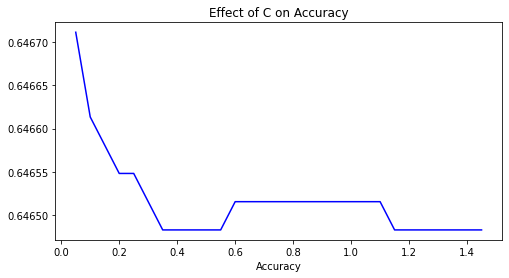

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals, train_accuracy_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.xlabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

Because the lowest C has the highest accuracy, we check if that just continues if we look at smaller values or if we can find a maximum: 

In [ ]:
# make an array of C values to check
c_vals_small_1 = np.array([0.001, 0.005])
c_vals_small_2 = np.arange(0.01, 0.05, 0.01)
c_vals_small = np.concatenate((c_vals_small_1, c_vals_small_2))

train_accuracy_small_vec = np.empty(c_vals_small.size, dtype=float)

for i in range(c_vals_small.size):
   lgr_C_small_i = LogisticRegression(solver='sag', random_state=rs, C=c_vals_small[i])
   results_lgr_C_small_i = cross_validate(lgr_C_small_i, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
   scores_lgr_C_small_i = results_lgr_C_small_i['test_score']
   train_accuracy_small_vec[i] = scores_lgr_C_small_i.mean()

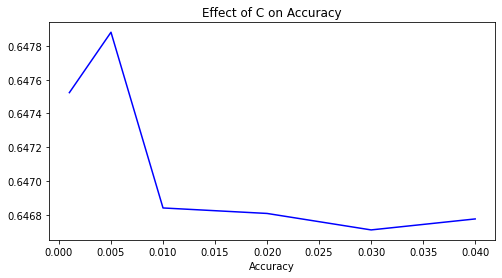

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals_small, train_accuracy_small_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.xlabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

We found a maximum at 0.005, but let's try to isolate this a little more:

In [ ]:
# make an array of C values to check
c_vals_smaller_1 = np.array([0.0001, 0.0005])
c_vals_smaller_2 = np.arange(0.001, 0.011, 0.001)
c_vals_smaller = np.concatenate((c_vals_smaller_1, c_vals_smaller_2))

train_accuracy_smaller_vec = np.empty(c_vals_smaller.size, dtype=float)

for i in range(c_vals_smaller.size):
   lgr_C_smaller_i = LogisticRegression(solver='sag', random_state=rs, C=c_vals_smaller[i])
   results_lgr_C_smaller_i = cross_validate(lgr_C_smaller_i, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
   scores_lgr_C_smaller_i = results_lgr_C_smaller_i['test_score']
   train_accuracy_smaller_vec[i] = scores_lgr_C_smaller_i.mean()

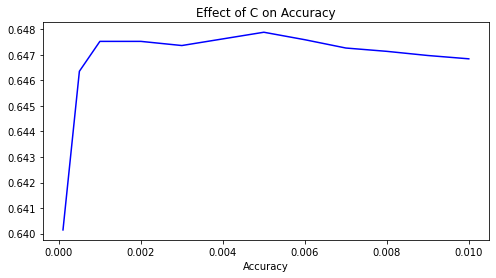

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals_smaller, train_accuracy_smaller_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.xlabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

Even after looking in more detail, the optimal C is 0.005, so that is the value we use. We now setup the logistic regression model using the optimal parameters:

In [ ]:
lgr_opt = LogisticRegression(solver='sag', random_state=rs, C=0.005)

We now return to determining the optimal max_abs_corr_features, the maximum allowed correlation among features.

In [ ]:
# *set threshold*
max_abs_corr_features = 1.00

cols_drop_high_abs_corr = features_abs_correlations_sorted_sel.loc[features_abs_correlations_sorted_sel['abs_correlation'] > max_abs_corr_features]['feature_2']

# remove features
onp_df_lgr = onp_df_tfm.copy()
onp_df_lgr = onp_df_lgr.drop(columns=cols_drop_high_abs_corr)

Separate out X_lgr (features) and y_lgr (outcome):

In [ ]:
X_lgr = onp_df_lgr.loc[:, ~onp_df_lgr.columns.isin(['shares', 'shares_class'])]
y_lgr = onp_df_lgr['shares_class']

We obtain a standard scale for the features optimize the logistic regression. Each feature is transformed by removing its mean and scaling it to a unit variance.

In [ ]:
scaler_lgr = StandardScaler()
X_lgr_scaled_ndarray = scaler_lgr.fit_transform(X_lgr)
X_lgr_scaled = pd.DataFrame(X_lgr_scaled_ndarray, columns = X_lgr.columns.values)

Split data into training and test sets:

In [ ]:
X_lgr_scaled_train, X_lgr_scaled_test, y_lgr_train, y_lgr_test = train_test_split(X_lgr_scaled, y_lgr, test_size = 0.20, random_state = rs)

We use cross validation again in determining the optimal max_abs_corr_features: 

In [ ]:
start_time_lgr_opt_cv = time.time()
results_lgr_opt_cv = cross_validate(lgr_opt, X_lgr_scaled_train, y_lgr_train, cv=cv_folds, return_estimator=True)
print("--- %s seconds ---" % (time.time() - start_time_lgr_opt_cv))

--- 3.863996744155884 seconds ---


In [ ]:
n_iters_lgr_opt_cv = np.empty(cv_folds, dtype=int)  
for i in range(cv_folds):
   n_iters_lgr_opt_cv[i] = results_lgr_opt_cv['estimator'][i].n_iter_[0]
   # print coefficients to make sure they are acceptable
   print(results_lgr_opt_cv['estimator'][i].coef_[0])

scores_lgr_opt_cv = results_lgr_opt_cv['test_score']

[-1.60551380e-02 -9.80312116e-02 -6.60801167e-03 -2.52654954e-02
  7.36847932e-02 -4.76581609e-02 -1.92007282e-01 -8.46002981e-02
  1.81227420e-01  1.54081162e-01 -6.75637286e-02 -3.57757699e-02
 -8.73307145e-02 -7.76990550e-02 -5.59629902e-02  1.73780683e-02
  2.16083953e-01  1.62907403e-01  1.73986417e-01 -3.99662625e-02
 -1.48113463e-01 -2.17244150e-02  3.66687378e-02  9.50667850e-02
 -2.15273009e-02 -3.41330586e-02  3.40980442e-02  5.24000827e-02
 -2.51468407e-02 -3.50589960e-02 -2.57338758e-02  9.01143125e-03
  1.41455825e-02 -4.56983775e-03 -1.96311206e-04  1.52517794e-02
  4.59695302e-02 -1.95817109e-02  1.14400606e-01 -1.56664307e-01
  7.85356818e-02  7.10069417e-02 -2.74543529e-02 -4.63620060e-02
  9.16986670e-02  5.07432677e-02 -2.04840017e-01 -8.39987927e-02
 -1.03933549e-01 -7.97281060e-02  4.82759876e-01  1.04593523e-01
  6.49251801e-03  8.69566558e-02]
[-0.01214713 -0.0941119  -0.00839875 -0.01728431  0.07260781 -0.04509807
 -0.18539906 -0.09747183  0.17218362  0.15237657

In [ ]:
print('Number of Iterations:')
print(n_iters_lgr_opt_cv)
print('Scores:')
print(scores_lgr_opt_cv)
print('Mean Score:')
print(scores_lgr_opt_cv.mean())
print('Standard Deviation Score:')
print(scores_lgr_opt_cv.std())

Number of Iterations:
[17 17 17 17 17 16 16 17 18 18]
Scores:
[0.65258369 0.66038349 0.66070848 0.65225869 0.65388365 0.65485863
 0.65453364 0.64900877 0.65994798 0.6446684 ]
Mean Score:
0.6542835429439362
Standard Deviation Score:
0.004882539890086168


The following is a summary of the results for various settings for max_abs_corr_features:
*   max_abs_corr_features = 1.00, Mean Score = 0.6542835429439362, Std. Dev. Score = 0.004882539890086168, coefficients acceptable
*   max_abs_corr_features = 0.95, Mean Score = 0.6536010600060096, Std. Dev. Score = 0.004820101686559111, coefficients acceptable
*   max_abs_corr_features = 0.90, Mean Score = 0.6528209315898442, Std. Dev. Score = 0.004984426782545454, coefficients acceptable
*   max_abs_corr_features = 0.85, Mean Score = 0.6474909063554295, Std. Dev. Score = 0.004943731976263058, coefficients acceptable
*   max_abs_corr_features = 0.80, Mean Score = 0.6478809071710787, Std. Dev. Score = 0.004661499095143489, coefficients acceptable
*   max_abs_corr_features = 0.75, Mean Score = 0.6475558835996591, Std. Dev. Score = 0.005574416084463075, coefficients acceptable
*   max_abs_corr_features = 0.70, Mean Score = 0.6461257925638985, Std. Dev. Score = 0.004728693037939452, coefficients acceptable
*   max_abs_corr_features = 0.65, Mean Score = 0.6463858071948720, Std. Dev. Score = 0.004777737652436838, coefficients acceptable
*   max_abs_corr_features = 0.60, Mean Score = 0.6397231462256355, Std. Dev. Score = 0.005239381439673313, coefficients acceptable
*   max_abs_corr_features = 0.55, Mean Score = 0.6393331454099863, Std. Dev. Score = 0.005355581023518742, coefficients acceptable
*   max_abs_corr_features = 0.50, Mean Score = 0.6309152641795138, Std. Dev. Score = 0.004712694026403971, coefficients acceptable

The mean score is the largest when max_abs_corr_features is 1.00, that is, no features are excluded. There are no concerning values in the coefficients, but some are small, likely minimizing coefficients for features that are not needed Apparently, logistic regression can handle highly correlated features as long as the regularization is strong enough, which we achieved by setting C = 0.005.

We now fit the optimal regression model to all of the training data:

In [ ]:
lgr_opt = LogisticRegression(solver='sag', random_state=rs, C=0.005)

In [ ]:
start_time_lgr_opt = time.time()
lgr_opt.fit(X_lgr_scaled_train, y_lgr_train)
print("--- %s seconds ---" % (time.time() - start_time_lgr_opt))

--- 0.40944981575012207 seconds ---


Let's determine the number of iterations used and the score (mean accuracy) for the training data:

In [ ]:
n_iter_opt = lgr_opt.n_iter_[0]
score_opt_train = lgr_opt.score(X_lgr_scaled_train, y_lgr_train)
print('Number of iterations: ', n_iter_opt)
print('Score on training data: ', score_opt_train)

Number of iterations:  17
Score on training data:  0.655811232449298


The regression completed in 17 iterations and the score on the training data is 0.655811. This compares favorably the results for initial default model above, which completed in 31 iterations and had a score on the training data of 0.647913. There is a small improvement in the score after optimizing the model.

Let's determine the terms with the largest coefficients:

In [ ]:
features_coefficients_df = pd.DataFrame({'features': np.array(X_lgr_scaled_train.columns), 
                                         'coefficients': lgr_opt.coef_[0]})

features_coefficients_df_sort_max_pos = features_coefficients_df.sort_values(by='coefficients', ascending=False)

features_coefficients_df_sort_max_neg = features_coefficients_df.sort_values(by='coefficients')

These are the features with the top five largest positive coefficients: 

In [ ]:
features_coefficients_df_sort_max_pos[0:5]

,features,coefficients
50,log_kw_avg_avg,0.498426
16,weekday_is_saturday,0.216905
8,data_channel_is_socmed,0.183144
18,LDA_00,0.176966
17,weekday_is_sunday,0.158765


These are the features with the top five largest negative coefficients:

In [ ]:
features_coefficients_df_sort_max_neg[0:5]

,features,coefficients
46,log_kw_max_max,-0.205046
6,data_channel_is_entertainment,-0.190987
39,log_num_self_hrefs,-0.157781
20,LDA_02,-0.147306
48,log_kw_min_avg,-0.114621


We now apply the model to the test data:

In [ ]:
score_opt_test = lgr_opt.score(X_lgr_scaled_test, y_lgr_test)
print('Score on test data: ', score_opt_test)

Score on test data:  0.6527561102444098


The score on the test data is 0.652756, which is slightly less than the 0.655811 we obtained for the training data. The logistic regression model appears to perform similarly for data within and outside the training data.

Let's look at the dummy classifier to calculate the accuracy of always assigning the majority class and then compare this result to the result of the logistic regression classifier above. This dummy classifier gives a null accuracy baseline to which we can compare your model's performance.

In [ ]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_lgr_scaled_train, y_lgr_train)
score_dum_train = dummy.score(X_lgr_scaled_train, y_lgr_train)
score_dum_test = dummy.score(X_lgr_scaled_test, y_lgr_test)
print('Dummy accuracy for training data: ', score_dum_train)
print('Dummy accuracy for test data: ', score_dum_test)
print('Difference in accuracies for test data: ', score_opt_test-score_dum_test)

Dummy accuracy for training data:  0.5325663026521061
Dummy accuracy for test data:  0.5297711908476339
Difference in accuracies for test data:  0.12298491939677592


The dummy classifer score for the training data is 0.532566 and for the test data is 0.529771. A value close to 0.5 is expected, because the classes are defined by the side of the median on which the number of shares value fall. The logistic regression model performs substantially better than the dummy classifier.

Although it is important to have good accuracy, accuracy does not tell the whole story. The confusion matrix provides a deeper understanding of what is going on with a classification model's performance by showing how things are classified. It reveals which data points are classified correctly and which ones are not. Let's determine the confusion matrix for the test data:

In [ ]:
lgr_opt_predictions = lgr_opt.predict(X_lgr_scaled_test)
lgr_opt_confusion = confusion_matrix(y_lgr_test, lgr_opt_predictions, labels=[1, 0])
lgr_opt_confusion

array([[2830, 1245],
       [1426, 2191]])

The confusion matrix that we have the following:
*   TP (True Positive): 2830
*   TN (True Negative): 2191
*   FP (False Positive): 1426
*   FN (False Negative): 1245

There are important metrics we can compute from these confusion matrix values:
*   accuracy = (TP+TN)/(TP+TN+FP+FN)
*   precision = TP/(TP+FP), proportion of positive predictions that are correct
*   recall = TP/(TP+FN), proportion of instances in the positive class are correctly predicted


In [ ]:
lgr_opt_TP = 2830
lgr_opt_TN = 2191
lgr_opt_FP = 1426
lgr_opt_FN = 1245
lgr_opt_accuracy = (lgr_opt_TP+lgr_opt_TN)/(lgr_opt_TP+lgr_opt_TN+lgr_opt_FP+lgr_opt_FN)
lgr_opt_precision = lgr_opt_TP/(lgr_opt_TP+lgr_opt_FP)
lgr_opt_recall = lgr_opt_TP/(lgr_opt_TP+lgr_opt_FN)
print(lgr_opt_accuracy)
print(lgr_opt_precision)
print(lgr_opt_recall)

0.6527561102444098
0.6649436090225563
0.694478527607362


As a confirmation, the accuracy matches exactly what we obtained above. The precision is 0.664944 and the recall is 0.694479. There are no big deviations for any of these metrics, so we maintain confidence in the logistic regression model.

We can also look at the receiver operating characteristic (ROC) curve to further check on the logistic regression model:

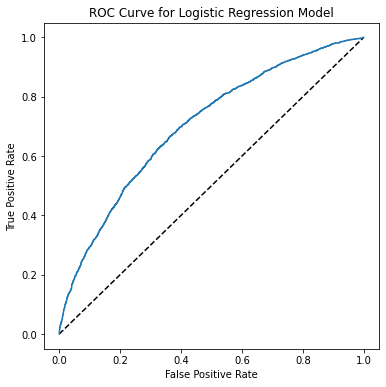

In [ ]:
lgr_opt_probs = lgr_opt.predict_proba(X_lgr_scaled_test)[:, 1]
lgr_opt_fpr, lgr_opt_tpr, lgr_opt_thresholds = roc_curve(y_lgr_test, lgr_opt_probs)
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lgr_opt_fpr, lgr_opt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.show()

Ideally, the path of the curve would go to the top left corner and have a strong bend there. That would indicate minimization of the false positive rate and maximization of the true positive rate. Our model falls short of this ideal. The dashed line is the 50% chance classifier baseline, which means classification just based on flipping a coin. Our curve is the correct side of this baseline and does have some amount of deviation from it. Another metric is the area under the curve but above the baseline (AUC):

In [ ]:
lgr_opt_auc = roc_auc_score(y_lgr_test, lgr_opt_probs)
print('Area under the ROC curve: {:.3f}'.format(lgr_opt_auc))

Area under the ROC curve: 0.702


This is pretty much all we can do with the logistic regression model, so we move onto the decision tree, which provides a nonlinear method for modeling the data. 

#####**Decision Tree**

The next model that we will try is decision tree, and work to build the best decision tree possible.



As a reminder, look at how many rows and features are present: 

In [ ]:
X_train.shape

(30768, 54)

First, we initialize the tree with default specifications, except for criterion:
*   criterion = 'entropy': The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
*   In the course, the focus was put on entropy as the criterion, so we start by using it here.

See https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html for more information.

In [ ]:
decision_tree_no_params = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs
)

We will use 10-fold cross validation to train the model. That means that in each fold, each data split will have 30,768/10 ~= 3,077 data points. By holding out one split in each fold for testing, we can test the performance of the tree for that fold, and that will allow us to optimize the tree parameters.

Carry out 10-fold cross validation:

In [ ]:
cv_folds = 10
results_dt_no_params = cross_validate(decision_tree_no_params, X_train, y_train, cv=cv_folds, return_estimator=True)

Look at scores for and characteristics of the decision trees. The scores returned are the mean accuracy for each fold.

In [ ]:
scores_dt_no_params = results_dt_no_params['test_score']

In [ ]:
depths_dt_no_params = np.empty(cv_folds, dtype=int)
n_leaves_dt_no_params = np.empty(cv_folds, dtype=int)
for i in range(cv_folds):
  depths_dt_no_params[i] = results_dt_no_params['estimator'][i].get_depth()
  n_leaves_dt_no_params[i] = results_dt_no_params['estimator'][i].get_n_leaves()

In [ ]:
print('Scores:')
print(scores_dt_no_params)
print('Tree Depths:')
print(depths_dt_no_params)
print('Number of Leaves:')
print(n_leaves_dt_no_params)

Scores:
[0.58433539 0.58628534 0.59408515 0.58563536 0.57946051 0.57328567
 0.59831004 0.58661033 0.58029909 0.5656697 ]
Tree Depths:
[35 38 43 41 36 35 41 37 38 38]
Number of Leaves:
[4099 4131 4098 4141 4142 4131 4143 4161 4150 4125]


Looking at these depths and numbers of leaves, these trees are likely too complex and are overfitting the test set in each fold. Let us try to adjust some of the parameters for DecisionTreeClassifier. We start with max_depth, which is the maximum depth of the tree. Above with the default parameters the nodes were expanded until all leaves were pure or contained less than 2 samples. 

In [ ]:
#md = 30
#md = 25
#md = 20
#md = 15
#md = 10
#md = 5
#md = 1
#md = 3
#md = 12
#md = 4
md = 7
#md = 6
#md = 8
#md = 2
#md = 9

decision_tree_md = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md
)

Carry out 10-fold cross validation:

In [ ]:
results_dt_md = cross_validate(decision_tree_md, X_train, y_train, cv=cv_folds, return_estimator=True)

Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_md = results_dt_md['test_score']

In [ ]:
print('Mean Score:')
print(scores_dt_md.mean())
print('Standard Deviation Score:')
print(scores_dt_md.std())

Mean Score:
0.638845139892309
Standard Deviation Score:
0.0067426423207673485


These are the results of varying max_depth (md) above:
*   max_depth = 1, mean(score) = 0.5912, std(score) = 0.0084
*   max_depth = 2, mean(score) = 0.6169, std(score) = 0.0069
*   max_depth = 3, mean(score) = 0.6298, std(score) = 0.0065
*   max_depth = 4, mean(score) = 0.634588, std(score) = 0.007306
*   max_depth = 5, mean(score) = 0.633645, std(score) = 0.007506
*   max_depth = 6, mean(score) = 0.636570, std(score) = 0.005834
*   max_depth = 7, mean(score) = 0.638845, std(score) = 0.006743
*   max_depth = 8, mean(score) = 0.636862, std(score) = 0.006221
*   max_depth = 9, mean(score) = 0.632832, std(score) = 0.008154
*   max_depth = 10, mean(score) = 0.633613, std(score) = 0.008394
*   max_depth = 12, mean(score) = 0.6261, std(score) = 0.0091
*   max_depth = 15, mean(score) = 0.6122, std(score) = 0.0058
*   max_depth = 20, mean(score) = 0.5936, std(score) = 0.0095
*   max_depth = 25, mean(score) = 0.5871, std(score) = 0.0106
*   max_depth = 30, mean(score) = 0.5834, std(score) = 0.0077


Based on the mean score, the optimal max_depth is 7. At the depths close to 7, the standard deviations are much lower than the means, so various trees have similar performance. The next parameter to test is min_samples_leaf, which is the minimum number of samples required to be at a leaf node; a split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. It defaults to 1, and increasing it may have the effect of smoothing the model.

In [ ]:
#msl = 1
#msl = 10
#msl = 50
#msl = 100
#msl = 500
#msl = 1000
#msl = 5
#msl = 3
#msl = 2
#msl = 4
#msl = 6
#msl = 7
#msl = 8
#msl = 9
#msl = 20
#msl = 30
#msl = 40
#msl = 45
#msl = 37
#msl = 43
#msl = 36
msl = 38
#msl = 39
#msl = 41
#msl = 42

decision_tree_msl = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
results_dt_msl = cross_validate(decision_tree_msl, X_train, y_train, cv=cv_folds, return_estimator=True)

Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_msl = results_dt_msl['test_score']

In [ ]:
print('Mean Score:')
print(scores_dt_msl.mean())
print('Standard Deviation Score:')
print(scores_dt_msl.std())

Mean Score:
0.6402427740021714
Standard Deviation Score:
0.006308658749072963


These are the results of varying min_samples_leaf (msl) above:
*   min_samples_leaf = 1, mean(score) = 0.6388451398923090, std(score) = 0.0067426423207673485
*   min_samples_leaf = 2, mean(score) = 0.6386826439547074, std(score) = 0.0065935644537283910
*   min_samples_leaf = 3, mean(score) = 0.6388451398923090, std(score) = 0.0066686130572774590
*   min_samples_leaf = 4, mean(score) = 0.6389101488327552, std(score) = 0.0064593495145052540
*   min_samples_leaf = 5, mean(score) = 0.6388451293269033, std(score) = 0.0065670531605896710
*   min_samples_leaf = 6, mean(score) = 0.6381626358235712, std(score) = 0.0065122558020531350
*   min_samples_leaf = 7, mean(score) = 0.6383251317611728, std(score) = 0.0062577340035394220
*   min_samples_leaf = 8, mean(score) = 0.6384226081929227, std(score) = 0.0062804065529952420
*   min_samples_leaf = 9, mean(score) = 0.6384225870621114, std(score) = 0.0065355091921632386
*   min_samples_leaf = 10, mean(score) = 0.6380000976243474, std(score) = 0.0063926893180276230
*   min_samples_leaf = 20, mean(score) = 0.6387153121887167, std(score) = 0.0043415528684204020
*   min_samples_leaf = 30, mean(score) = 0.6393979113461044, std(score) = 0.0059694136525036800
*   min_samples_leaf = 35, mean(score) = 0.6397228609596854, std(score) = 0.0061355058079386720
*   min_samples_leaf = 36, mean(score) = 0.6398853463318813, std(score) = 0.0060827305290209910
*   min_samples_leaf = 37, mean(score) = 0.6401778390195643, std(score) = 0.0061639805530552240
*   min_samples_leaf = 38, mean(score) = 0.6402427740021714, std(score) = 0.0063086587490729630
*   min_samples_leaf = 39, mean(score) = 0.6399827699366033, std(score) = 0.0058199061455843300
*   min_samples_leaf = 40, mean(score) = 0.6401127666866846, std(score) = 0.0054182057170642645
*   min_samples_leaf = 41, mean(score) = 0.6400477683116439, std(score) = 0.0050636231163286370 
*   min_samples_leaf = 42, mean(score) = 0.6398527414903054, std(score) = 0.0052477965136059590
*   min_samples_leaf = 43, mean(score) = 0.6393653065045285, std(score) = 0.0049532480158077200
*   min_samples_leaf = 45, mean(score) = 0.6387478325070483, std(score) = 0.0051009580116534265
*   min_samples_leaf = 50, mean(score) = 0.6389104446641110, std(score) = 0.0055607089544237900
*   min_samples_leaf = 100, mean(score) = 0.6375778828871281, std(score) = 0.0067837363703090230
*   min_samples_leaf = 500, mean(score) = 0.6356604308234297, std(score) = 0.0068846803713566280
*   min_samples_leaf = 1000, mean(score) = 0.6239275268118297, std(score) = 0.0068122548033099700

Overall, the mean score does not vary much with a wide range of min_samples_leaf values. However, we still came across two maxima, and that required a lot of searching to find the overall optimal value, which is min_samples_leaf = 38. Ideally, we would have done a joint search for the optimal max_depth and min_samples_leaf, but that may be somewhat beyond the time alloted for this project.

We now change the criterion to 'gini' to see if that changes the result significantly:

In [ ]:
decision_tree_gini = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
results_dt_gini = cross_validate(decision_tree_gini, X_train, y_train, cv=cv_folds, return_estimator=True)

Look at mean and standard deviation of scores for the decision trees:

In [ ]:
scores_dt_gini = results_dt_gini['test_score']

In [ ]:
print('Mean Score:')
print(scores_dt_gini.mean())
print('Standard Deviation Score:')
print(scores_dt_gini.std())

Mean Score:
0.6386506202104376
Standard Deviation Score:
0.006733853333749827


These are the results of changing criterion:
*   criterion = 'entropy', mean(score) = 0.6402, std(score) = 0.0063
*   criterion = 'gini', mean(score) = 0.6387, std(score) = 0.0067

There does not seem to be a benefit to using 'gini', but at the same time there is not much of a drop in score when using 'gini'. We will just continue with using 'entropy'.

We now determine a single tree using the optimal parameters and all of the training data:

In [ ]:
md = 7
msl = 38
decision_tree_opt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

In [ ]:
decision_tree_opt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=38,
                       random_state=7)

Obtain the prediction and score for applying the optimal tree to the test data:

In [ ]:
y_test_pred_dt = decision_tree_opt.predict(X_test)
score_dt_opt_test = decision_tree_opt.score(X_test, y_test)

In [ ]:
score_dt_opt_test

0.6436557462298492

The mean accuracy of the optimal decision tree model in predicting the test data is 0.6437. This is very close to and slightly larger than what we obtained above for the training folds above.

Let's create a visualization for the optimal tree:

In [ ]:
#render and visualize the tree
dot_data = tree.export_graphviz(
    decision_tree_opt, out_file=None,
    feature_names=X_train.columns,
    class_names=['Not Popular', 'Popular'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

The tree is difficult to view in Jupyter Noteboook, so it was saved as a png for more detailed review. The top node rule is log_kw_avg_avg <= 3.465. On the true (left) side of the top node, the next node is data_channel_is_tech <= 0.5, which in turn has data_channel_is_socmed <= 0.5 on its true side and weekday_is_saturday <= 0.5 on its false side. On the false (right) side of the top node, the next node is data_channel_is_entertainment <= 0.5, which in turn has log_self_reference_min_shares <= 3.218 on its true side and weekday_is_sunday <= 0.5 on its false side. The tree then grows from there.

#####**Random Forest**



In order to try and improve the performance of decision tree, we now use random forest. The initial random forest here uses the parameters we determined above for a single decision tree but otherwise uses the default random forest parameters. The default n_estimators, the number of trees in the forest, is 100.

In [ ]:
md = 7
msl = 38
random_forest_initial = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

Carry out 10-fold cross validation:

In [ ]:
cv_folds = 10
start_time_rf_initial = time.time()
scores_rf_initial = cross_val_score(random_forest_initial, X_train, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_initial))

--- 80.00529146194458 seconds ---


Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_initial.mean())
print('Standard Deviation Score:')
print(scores_rf_initial.std())

Mean Score:
0.6581188802529612
Standard Deviation Score:
0.0057108751060678895


The mean score is 0.6581, which is a small improvement over the optimal cross validation mean score above for decision tree, 0.6402. There are some parameters in RandomForestClassifier that we can investigate. By default, bootstrap samples are used when building trees. When bootstrap is used, we can control max_samples, the number of samples to draw from X_train to use in training each base estimator. There does not seem to be any real benefit to lowering X_samples, as the time it takes to do the random forest cross validation is not too long (86 seconds). If bootstrap is not used, the whole dataset is used to build each tree. Let's look at the impact of turning bootstrap off:

In [ ]:
random_forest_no_bootstrap = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl,
    bootstrap = False
)

Carry out 10-fold cross validation:

In [ ]:
start_time_rf_no_bootstrap = time.time()
scores_rf_no_bootstrap = cross_val_score(random_forest_no_bootstrap, X_train, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_no_bootstrap))

--- 119.94082117080688 seconds ---


Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_no_bootstrap.mean())
print('Standard Deviation Score:')
print(scores_rf_no_bootstrap.std())

Mean Score:
0.6578911640668023
Standard Deviation Score:
0.005652439104448003


The mean score decreases slightly from 0.6581 to 0.6579 when turning bootstrap off. We now try turning bootstrap back on and also turn on warm_start, which reuses the solution of the previous call to fit and add more estimators to the ensemble, instead of fitting a whole new forest.

In [ ]:
random_forest_warm_start = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl,
    warm_start = True
)

Carry out 10-fold cross validation:

In [ ]:
start_time_rf_warm_start = time.time()
scores_rf_warm_start = cross_val_score(random_forest_warm_start, X_train, y_train, cv=cv_folds)
print("--- %s seconds ---" % (time.time() - start_time_rf_warm_start))

--- 78.20399761199951 seconds ---


Look at mean and standard deviation of scores for the random forests:

In [ ]:
print('Mean Score:')
print(scores_rf_warm_start.mean())
print('Standard Deviation Score:')
print(scores_rf_warm_start.std())

Mean Score:
0.6581188802529612
Standard Deviation Score:
0.0057108751060678895


These results are exactly the same as the case with bootstrap on and warm_start at the default of False, so we will just leave warm_start at its default as it seems to have no effect. Now that we have looked at these parameters, let's set the optimal model, which is the initial default one. We now fit it to all of the training data.

In [ ]:
md = 7
msl = 38
random_forest_opt = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state = rs,
    max_depth = md,
    min_samples_leaf = msl
)

In [ ]:
start_time_rf_opt = time.time()
random_forest_opt.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time_rf_opt))

--- 9.111050128936768 seconds ---


Obtain the prediction and score for applying the optimal forest to the test data:

In [ ]:
y_test_pred_rf = random_forest_opt.predict(X_test)
score_rf_opt_test = random_forest_opt.score(X_test, y_test)

In [ ]:
score_rf_opt_test

0.6647165886635465

The mean accuracy of the optimal random forest model in predicting the test data is 0.6647. This is a small improvement over the mean accuracy for the optimal decision tree model, 0.6437.


Random forest models are not conducive to visualizations as with a single decision tree, so no visualizations are presented here.

#####**Kernel Support Vector Machine Classifier**

We try one more model, kernel support vector machine classification (SVC). Kernel SVC allows nonlinear methods to be used. Linear support vector machine and logistic regression both optimize linear boundaries between classes, so looking at linear support vector machine may not add very much. Let's start by setting up the model with initial default settings:

In [ ]:
svm_initial = SVC(
    random_state = rs
)

The default kernel used in the algorithm is ‘rbf’ (radial basis function), which the course says should be used unless there is a good reason not to use it. Fit the initial model to the training data:

In [ ]:
start_time_svm_initial = time.time()
svm_initial.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time_svm_initial))

--- 71.58739423751831 seconds ---


Let's look at the score in using the default model on the training data (mean accuracy):

In [ ]:
score_svm_initial = svm_initial.score(X_train, y_train)
print('Score on training data: ', score_svm_initial)

Score on training data:  0.655746229849194


The mean accuracy of the model on the training data is 0.655746.

We now look at the impact of varying parameter 'C', which is the inverse of regularization strength that defaults to 1. Smaller values specify stronger regularization. The penalty is a squared l2 penalty. For the sake of time, we only use 5 folds in the cross validation.

In [ ]:
# make an array of C values to check
#c_vals = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5]) 
# The above set showed that the highest accuracy is at 0.5, and it takes a long time to run so now turned off.
c_vals = np.array([0.5, 0.75, 1.00, 1.25])

train_accuracy_vec = np.empty(c_vals.size, dtype=float)

cv_folds = 5

start_time_svm_C_loop = time.time()
for i in range(c_vals.size):
    svm_C_i = SVC(random_state=rs, C=c_vals[i])
    results_svm_C_i = cross_validate(svm_C_i, X_train, y_train, cv=cv_folds, return_estimator=True)
    scores_svm_C_i = results_svm_C_i['test_score']
    train_accuracy_vec[i] = scores_svm_C_i.mean()
    print(i)
    print("--- %s seconds ---" % (time.time() - start_time_svm_C_loop))

0
--- 288.48085141181946 seconds ---
1
--- 568.5267555713654 seconds ---
2
--- 846.2801008224487 seconds ---
3
--- 1121.5464911460876 seconds ---


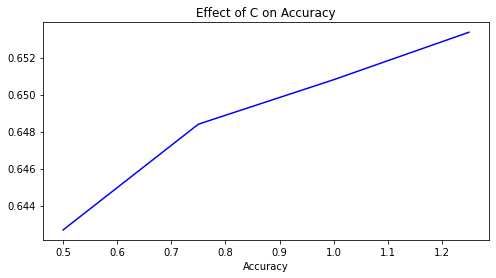

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(c_vals, train_accuracy_vec, '-b', label='Train Accuracy')
plt.xlabel('C')
plt.xlabel('Accuracy')
plt.title('Effect of C on Accuracy')
plt.show()

It is not completely clear what this result means, so we will just leave C at the default value of 1. In that case, the initial default model is also our optimal model. Let's determine the score on the test data:

In [ ]:
score_svm_test = svm_initial.score(X_test, y_test)
print('Score on test data: ', score_svm_test)

Score on test data:  0.6539261570462819


#####**Summary**

This table summarizes how well each optimized model performs on the test data:

| Model Type | Mean Accuracy |
| --- | --- |
| Logistic Regression | 0.652756 |
| Decision Tree | 0.643656 |
| Random Forest | 0.664717 |
| Kernel Support Vector Machine Classifier | 0.653926 |

Of the models, random forest is the best, but the range of accuracies among the models is quite small. That is, it appears that any of the models would provide approximately the same predictive power.

In the article cited at the top of this project, the authors obtained accuracies of 0.67 for random forest, which was their top model, and 0.66 for support vector machine. We have done nearly just as well here.

Only logistic regression and decision tree models provide explanatory power, in letting us see which features are the most important. The most important features in the optimal logistic regression are for positive coefficients: log_kw_avg_avg,  weekday_is_saturday, data_channel_is_socmed, LDA_00, and weekday_is_sunday and for negative coefficients: log_kw_max_max, data_channel_is_entertainment, log_num_self_hrefs, LDA_02, and log_kw_min_avg. The most important features in the optimal decision tree are log_kw_avg_avg, data_channel_is_tech, data_channel_is_socmed, weekday_is_saturday,  data_channel_is_entertainment, log_self_reference_min_shares, and weekday_is _sunday. Interestingly, there is clearly some overlap in the most important features in the two models, which have very different algorithms.





